# Stock Deep Recurrent Q-Network 
This notebook provides an implementation of a Deep Double Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. This notebook applies the technique on time series.

In [71]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
import itertools
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
from helper import *
#from C51 import *
from StockEnv import StockEnv
import pandas as pd
from GeometricBrownianMotion import * 
from MCSAmericanOptionPricing import *
import math

seed = 1 #time.time()
random.seed(seed)
print('Seed is:' + str(seed))

Seed is:1


### Variable settings

In [72]:
"""So = 100 #spot_price #110 #90 #100 110 #127.62 #90
strike_price = 100 #130 #100
mu = 10/100 #risk_free_rate #0.001 #5/100
sigma = 0.20 #volatility # the historical vols or implied vols
dividend_rate = 0.0 #0.0163 #dividend yield of 1.63%
num_seeds = 20000"""
risk_free_rate = 5/100
mu = risk_free_rate
sigma = 0.20
num_seeds = 60

In [73]:
save_model_freq = 10000 #5000
Normalization = False
Window_Normalization = False #True #False
test_data_ratio = 0.2 #0.3 # 0.2

architecture = 0 #3 #0 #1 #2 #3 #4 #5
nbFilters = 32 #16 #1
paddingType = 'same' #'causal' # 'valid'
huber_loss = True #False
dueling_type = 'max' #'naive'
mask_type = 'default' #'maskFirstHalf' # 'maskByWeights' 'default'
apply_dropout = True
batch_size = 64 #16 #32 #128 #60 #20 #4 #How many experience traces to use for each training step.
memory_capacity = 3000 #3000 #1000
learning_rate = 0.0025 #0.00025 #0.01 0.025 0.0025 0.0001
apply_grad_clipping = True
grad_clipping = 5 # Maybe test with bigger values, e.g. 40 or 30
optimizer_type = 'Adam' # 'GradientDescent' 'RMSProp'

Colab = False
scriptDirectory = os.getcwd() #"C:\Code_RL\2019_11_21_shuffled_GBM_version" #"C:\\Code_RL" # os.getcwd()

history_t = 15 #5 #15 #2 #15 ##
option_T = 50 #65 #50 #100 #365 #100 #200 #365 #65 #30 #15 #40 #30 ##
#build_warm_up_state_t = option_T // 3 #option_T // 2
input_size = history_t + 2
is_training = True

In [74]:
"""stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(test_data)), test_data, color='r') """

"stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',\n              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',\n              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',\n              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',\n              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',\n               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',\n               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',\n               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',\n              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',\n               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',\n               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',\n              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',\n               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',\n              

##hpq.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 8.53125, max value of data: 22.20295
train_size: 733
test_size: 183
##aapl.us.txtmin date: 1984-09-07max date: 2017-11-10
min value of data: 68.814, max value of data: 174.825
train_size: 733
test_size: 183
##goog.us.txtmin date: 2014-03-27max date: 2017-11-10
min value of data: 491.77, max value of data: 1035.9850000000001
train_size: 733
test_size: 183
##ibm.us.txtmin date: 1962-01-02max date: 2017-11-10
min value of data: 110.81, max value of data: 176.43
train_size: 733
test_size: 183
##ups.us.txtmin date: 1999-11-10max date: 2017-11-10
min value of data: 83.2025, max value of data: 119.64
train_size: 733
test_size: 183
##jnj.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 83.78399999999999, max value of data: 143.231
train_size: 733
test_size: 183
##msft.us.txtmin date: 1986-03-13max date: 2017-11-10
min value of data: 35.632999999999996, max value of data: 84.905
train_size: 733
test_size: 1

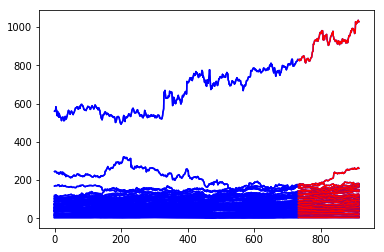

In [75]:
stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r')

### Load the game environment

Setting our environment

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 626
num_episodes_per_epoch: 40080
min value of stock: 79.153, max value of stock: 123.065


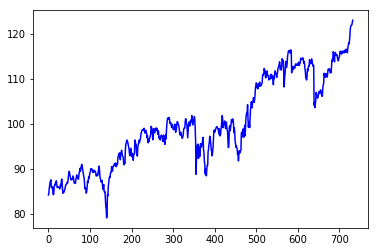

In [76]:
############################################################################
#env = StockEnv(train_data, risk_free_rate, history_t=history_t, option_T=option_T)
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [77]:
num_actions = 2
num_atoms=51
vmax=float(10.)
vmin=float(-1.)
delta_z = (vmax - vmin) / float(num_atoms - 1)
_support = [vmin + i * delta_z for i in range(num_atoms)]

### Implementing the network itself

In [78]:
class Qnetwork():
    def __init__(self,myScope):
        
        self._support = tf.linspace(vmin, vmax, num_atoms)
        
        self.scalarInput = tf.placeholder(shape=[None,input_size],dtype=tf.float32)
        
        # depending on the chosen architecture, data is processed through differents layers
        
        # convolutions are used in all type, except architecture 0 which only uses LSTM
        if architecture != 0:
          self.InputConvIn = tf.reshape(self.scalarInput,shape=[-1,input_size,1], name='InputConvIn')
          self.conv1 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.InputConvIn)
        
        if architecture == 0: # LSTM only
          self.scalarInputFlattened = tf.keras.layers.Flatten()(self.scalarInput)
        elif architecture == 1: # only one convolution
          self.conv1flattened = tf.reshape(self.conv1,shape=[-1,self.conv1.shape[1]*self.conv1.shape[2]], name='conv1flattened')
        elif architecture == 2: # only one convolution followed by max pooling
          self.maxPooling1D = tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.maxPooling1Dflattened = tf.reshape(self.maxPooling1D,shape=[-1,self.maxPooling1D.shape[1]*self.maxPooling1D.shape[2]], name='maxPooling1Dflattened')
        elif architecture == 3: # only one convolution followed by average pooling
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.AveragePooling1Dflattened = tf.reshape(self.AveragePooling1D,shape=[-1,self.AveragePooling1D.shape[1]*self.AveragePooling1D.shape[2]], name='AveragePooling1Dflattened')  
        elif architecture == 4: #VGG (one block of 2 convolutions followed by avg pooling)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.conv1)
          self.AveragePooling1D4 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened4 = tf.reshape(self.AveragePooling1D4,shape=[-1,self.AveragePooling1D4.shape[1]*self.AveragePooling1D4.shape[2]], name='AveragePooling1Dflattened4')
        elif architecture == 5: #Lenet (conv, avg pooling, conv, avg pooling)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,#5, #3, #maybe unstable calculations because of 5 instead of 3
                                               strides=1,
                                               padding= paddingType, #'same',
                                               #activation=tf.keras.activations.hard_sigmoid
                                               #activation=tf.keras.activations.sigmoid
                                               #activation=tf.keras.activations.tanh
                                               activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.AveragePooling1D5 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened5 = tf.reshape(self.AveragePooling1D5,shape=[-1,self.AveragePooling1D5.shape[1]*self.AveragePooling1D5.shape[2]], name='AveragePooling1Dflattened5')
        elif architecture == 6: #Googlenet (Inception net: combine (conv&avgPooling) + conv1 + conv3 + conv5)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv11 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=1,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv3 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=3,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv5 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=5,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.filterconcatenation = tf.concat([self.conv11, self.conv3, self.conv5, self.AveragePooling1D], 2, name = 'filterconcatenation')
          self.filterconcatenationflattened = tf.reshape(self.filterconcatenation,shape=[-1,self.filterconcatenation.shape[1]*self.filterconcatenation.shape[2]], name='filterconcatenationflattened')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
 
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        if architecture == 0:
          self.convFlat = tf.reshape(self.scalarInputFlattened,[self.batch_size,self.trainLength,input_size])
        elif architecture == 1:
          self.convFlat = tf.reshape(self.conv1flattened,[self.batch_size,self.trainLength,self.conv1flattened.shape[1]])
        elif architecture == 2:
          self.convFlat = tf.reshape(self.maxPooling1Dflattened,[self.batch_size,self.trainLength,self.maxPooling1Dflattened.shape[1]])
        elif architecture == 3:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened.shape[1]])
        elif architecture == 4:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened4,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened4.shape[1]])
        elif architecture == 5:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened5,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened5.shape[1]])
        elif architecture == 6:
          self.convFlat = tf.reshape(self.filterconcatenationflattened,[self.batch_size,self.trainLength,self.filterconcatenationflattened.shape[1]])
        
        # use cudnn-based cells to leverage Nvidia GPUs
        single_cell = lambda: tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(h_size)
    
        # NOTE: Even if there's only one layer, the cell needs to be wrapped in MultiRNNCell.
        lstm_cells = [single_cell() for _ in range(num_layers)]
        if is_training and apply_dropout and dropout < 1:
            lstm_cells = [tf.contrib.rnn.DropoutWrapper(
                lstm, input_keep_prob=1.0, output_keep_prob=1.0 - dropout, state_keep_prob=1.0 - dropout
            ) for lstm in lstm_cells]
        multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells, state_is_tuple=True)

        self.state_in = tf.placeholder(tf.float32, [num_layers, 2, None, h_size])
        state_per_layer_list = tf.unstack(self.state_in, axis=0)
        rnn_tuple_state = tuple(
            [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )
        
        # calculate the real length of each episode (since remaining states are filled with 0s after selling)
        # This is required by RNN 
        self.seq_len = length(self.convFlat)
        
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                cell=multi_cell,
                inputs=self.convFlat,                                    
                dtype=tf.float32,
                initial_state=rnn_tuple_state, 
                sequence_length=self.seq_len,
                scope=myScope+'_lstm')
        

        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        
        self.weights_initializer = tf.contrib.slim.variance_scaling_initializer(factor=1.0 / np.sqrt(3.0), mode='FAN_IN', uniform=True)
        self.net = tf.contrib.slim.fully_connected(
              self.rnn, #self.net,
              num_actions * num_atoms,
              activation_fn=None,
              weights_initializer=self.weights_initializer)

        self.logits = tf.reshape(self.net, [-1, num_actions, num_atoms])
        self.probabilities = tf.contrib.layers.softmax(self.logits)
        self.q_values = tf.reduce_sum(self._support * self.probabilities, axis=2)
        
        self.predict = tf.argmax(self.q_values,1)
        
            
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)    
        # create placeholder for target_distribution
        self.target_distribution = tf.placeholder(shape=[None,num_atoms],dtype=tf.float32)

        # size of indices: batch_size x 1.
        self.indices = tf.range(tf.shape(self.logits)[0])[:, None]
        # size of reshaped_actions: batch_size x 2.
        self.reshaped_actions = tf.concat([self.indices, self.actions[:, None]], 1)
        # For each element of the batch, fetch the logits for its selected action.
        self.chosen_action_logits = tf.gather_nd(self.logits,
                                            self.reshaped_actions)

        self.td_error = tf.nn.softmax_cross_entropy_with_logits(labels=self.target_distribution,logits=self.chosen_action_logits)
        # In order to only propogate accurate gradients through the network, we can mask the first
        # half of the losses for each trace as per Lample & Chaplot 2016
        # We can also use gradual weights to avoid neglecting short episodes at the beginning
        # maybe seq_len used in averaging should also change subsequently !
        if mask_type == 'maskFirstHalf':
            self.maskA = tf.zeros([self.batch_size,self.trainLength//2])
            self.maskB = tf.ones([self.batch_size,self.trainLength//2])
            self.mask = tf.concat([self.maskA,self.maskB],1)
            self.mask = tf.reshape(self.mask,[-1])
            self.td_error = self.td_error * self.mask
        elif mask_type == 'maskByWeights': 
            #self.mask_weights = tf.range(start=0, limit=1, delta=1/self.trainLength)
            self.mask_weights = tf.range(start=0.1, limit=1, delta=0.9/tf.cast(self.trainLength, tf.float32))
            self.mask = tf.tile(self.mask_weights, [self.batch_size])
            self.td_error = tf.multiply(self.td_error, tf.cast(self.mask, tf.float32))
        elif mask_type == 'default':
            self.td_error = self.td_error
        
        # divide by the real length of episodes instead of averaging which is incorrect
        self.loss = tf.cast(tf.reduce_sum(self.td_error), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)
        self.check_ops = tf.debugging.check_numerics( self.loss, "self.loss contain Nan or Inf", name="self.check_ops")
        
        if optimizer_type == 'Adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        elif optimizer_type == 'GradientDescent':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        elif optimizer_type == 'RMSProp':
            optimizer = tf.train.RMSPropOptimizer(learning_rate)
        
        if apply_grad_clipping:
            # calculate gradients and clip them to handle outliers
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars), grad_clipping)
            self.updateModel = optimizer.apply_gradients(
                    zip(grads, tvars),
                    # global_step=tf.contrib.framework.get_or_create_global_step(),
                    name="updateModel")
        else:
            self.updateModel = optimizer.minimize(self.loss, name="updateModel")

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [79]:
class experience_buffer():
    def __init__(self, buffer_size = memory_capacity, build_warm_up_state_t=build_warm_up_state_t):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        #sampled_episodes = np.array(sampled_episodes)
        sampled_episodes = self.processEpisodes(sampled_episodes)
        return np.reshape(sampled_episodes,[-1,5])
    
    def processEpisodes(self,sampled_episodes):
        sampledTraces = []
        for episode in sampled_episodes:
            sampledTraces.append(episode[build_warm_up_state_t:])
        sampledTraces = np.array(sampledTraces)
        return sampledTraces

### Training the network

In [80]:
#Setting the training parameters
num_layers = 3 # Number of layer of LSTM
h_size = 512 #256 #512 #128 #512 #256 #512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
keep_prob = 0.8
dropout = 1 - keep_prob  # dropout amount
update_freq = 5 #30 #10 #5 #How often to perform a training step.
update_online_freq = 5 #10 #5 #3 #5
update_target_freq = 30 #300 #30
#gamma = discount_factor #.99 #.95 #1 #Discount factor on the target Q-values
gamma = env.get_discount_factor(1) # discount for 1 day
startE = 1 #0.1 #1 #Starting chance of random action
endE = 0.1 #0.01 #0.1 #Final chance of random action
num_epochs = 5
num_episodes = env.get_total_num_episodes_per_epoch()*num_epochs #30 #50000 #20000 #100000 #20000 #3000 #20000 #30000 #10000 #4000 #100000 #40000
pre_train_episodes = int(memory_capacity * 0.1) # 0.25 300 #300 #200 #600 #200
annealing_episodes = int(num_episodes * 0.3) #4*memory_capacity #0.7*memory_capacity #400 #memory_capacity #400
pre_exploitation_episodes = int(num_episodes * 0.6)
annealing_exploitation_episodes = int(num_episodes * 0.25)
exploitationE =  0.01 #0.008 #0.02
load_model = False #Whether to load a saved model.
path = os.path.join(scriptDirectory, 'savedModel') #The path to save our model to.
max_epLength = option_T #env.get_max_episode_time() #option_T + build_warm_up_state_t
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000
summaryEpoch = env.get_total_num_episodes_per_epoch()
tau = 0.001 # learning rate (also referred to as step size) for target network
softUpdate = True #False # use soft or hard updates
#trained_model_name = os.path.join(path, 'architecture' + str(architecture) + '-option_T' + str(option_T) + '-history_t' + str(history_t) + '-num_episodes' + str(num_episodes) + '-tau' + str(tau) + '-softUpdate' + str(softUpdate) + '-dropout' + str(dropout) + '-mask' + str(mask_type) + '-dueling_type' + str(dueling_type) + '-So' + str(So) + '-strike_price' + str(strike_price) + '-mu' + str(mu) + '-sigma' + str(sigma) + '-num_seeds' + str(num_seeds))
trained_model_name = os.path.join(path, 'C51_yahoo_arch' + str(architecture)\
                    + '-option_T' + str(option_T) + '-history_t' + str(history_t)\
                    + '-num_episodes' + str(num_episodes)\
                    + '-softUpdate' + str(softUpdate) + '-tau' + str(tau)\
                    + '-dropout' + str(dropout) + str(apply_dropout)\
                    + '-num_layers' + str(num_layers) #+ '-apply_dropout' + str(apply_dropout)\
                    + '-freq' + str(update_target_freq) + '-batch' + str(batch_size)\
                    + '-capacity' + str(memory_capacity) + '-lambda' + str(learning_rate))
#final_trained_model_name = trained_model_name + '-final'
final_trained_model_name = "C51_yahoo_arch0-option_T50-history_t15-num_episodes200400-softUpdateTrue-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-120000"
final_trained_model_name = os.path.join(path, final_trained_model_name)
exploration_type = 'Random'
print('#num_episodes: ' + str(num_episodes))
print('#trace_length: ' + str(trace_length))
#print('#discount_factor: ' + str(discount_factor))
print('#gamma: ' + str(gamma))

#num_episodes: 200400
#trace_length: 38
#gamma: 0.9998016069840849


In [ ]:
begin_time = time.time()
tf.reset_default_graph()
#We define the primary and target q-networks
mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=5)

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau,softUpdate)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
# amounts by which to anneal
episodeDrop = (startE - endE)/annealing_episodes

episodeDrop2 = (endE - exploitationE)/annealing_exploitation_episodes

#create lists to contain total rewards, steps per episode, sell time and epsilon
jList = []
rList = []
sTimeList = [] # sell time list
eList = []

percentage_rList = []
real_percentage_rList = []

NonRandom_percentage_rList = []
NonRandom_real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

NonRandom_option_percentage_rList = []
NonRandom_option_real_percentage_rList = []

#Non random day Lists
NonRandomrList = []
NonRandomsTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
AvgEpisodeListEpoch = []
AvgrListEpoch = []
AvgsTimeListEpoch = []

AvgLossList = []
AvgQSellLossList = []

AvgLossListEpochTemp = [] # Temp
AvgLossListEpoch = [] # permanent

AvgMainQList = []
AvgTargetQList = []
AvgMainMaxQList = []
AvgMainHoldQList = []
AvgMainSellQList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

# Non random days
AvgNonRandomrList = []
AvgNonRandomsTimeList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)  

#Some config to parralelize and leverage the GPU capabilities.
config = tf.ConfigProto()
config.intra_op_parallelism_threads = 0 #16 #44
config.inter_op_parallelism_threads = 0 #16 #44
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
#config.device_count = {"CPU": 4}, # limit to num_cpu_core CPU usage 
#config.log_device_placement = True
#tf.Session(config=config)

with tf.Session(config=config) as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
   
    updateTarget(targetOps,sess) #Update the target network.
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the lstm's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        
        if exploration_type == 'Random' and np.random.rand(1) < e:
            sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        else:
            sell_time = -1
            
        while j < max_epLength: 
            #Choose an action greedily (with e chance of random action) from the Q-network
            if env.is_episode_finished(): # fill with empty state till the end to have episodes of equal length to train
                a = 0 # arbitrary
                s1P,r,d = env.empty_step()
            else:
                if i < pre_train_episodes or env.get_time() < build_warm_up_state_t or sell_time != -1:    
                    #construct the state for following steps of same episode
                    if sell_time != -1:
                        state1 = np.zeros((num_layers, 2, 1, h_size))
                    else:
                        state1 = sess.run(mainQN.rnn_state,\
                            feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                    
                    if env.get_time() < build_warm_up_state_t or env.get_payoff() <= 0:
                        a = 0 #hold
                    elif sell_time != -1:
                        if j == sell_time and d == False:
                            a = 1
                        else:
                            a = 0
                    elif j == max_epLength - 1 and d == False:
                        a = 1
                    else:
                        a = np.random.randint(0,2)

                else:
                    a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                    a = a[0]
            
                s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        eList.append(e)
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        if sell_time == -1:
            NonRandomrList.append(rAll)
            NonRandomsTimeList.append(env.get_sell_time() + 1)
            
            stock_percentage_return, option_percentage_return = env.get_percentage_return()
            NonRandom_percentage_rList.append(stock_percentage_return)
            NonRandom_option_percentage_rList.append(option_percentage_return)
            stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
            NonRandom_real_percentage_rList.append(stock_percentage_return)
            NonRandom_option_real_percentage_rList.append(option_percentage_return)

        if i >= pre_train_episodes:
            #Reset the lstm's hidden state
            state_train = np.zeros((num_layers, 2, batch_size, h_size))
            #Get a random batch of experiences.
            trainBatch = myBuffer.sample(batch_size)
            #Below we perform the Double-DQN update to the target Q-values
            num_samples = batch_size*trace_length
            m_prob = np.zeros((num_samples, num_atoms))

            # Get Optimal Actions for the next states (from distribution z)
            
            optimal_action_idxs = sess.run([mainQN.predict], feed_dict={\
                                mainQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            optimal_action_idxs = np.reshape(optimal_action_idxs, [-1, 1])
            probabilities = sess.run(targetQN.probabilities, feed_dict={\
                                targetQN.scalarInput:np.vstack(trainBatch[:,3]),\
                                targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
            
            for s in range(num_samples):
                if trainBatch[s,4]:
                    # Distribution collapses to a single point
                    Tz = min(vmax, max(vmin, trainBatch[s,2]))
                    bj = (Tz - vmin) / delta_z 
                    m_l, m_u = math.floor(bj), math.ceil(bj)
                    m_prob[s, int(m_l)] += (m_u - bj)
                    m_prob[s, int(m_u)] += (bj - m_l)
                    
                else:
                    for j in range(num_atoms):
                        Tz = min(vmax, max(vmin, trainBatch[s,2] + gamma * _support[j]))
                        bj = (Tz - vmin) / delta_z 
                        m_l, m_u = math.floor(bj), math.ceil(bj)
                        m_prob[s, int(m_l)] += probabilities[s, optimal_action_idxs[s], j] * (m_u - bj)
                        m_prob[s, int(m_u)] += probabilities[s, optimal_action_idxs[s], j] * (bj - m_l)

            loss, _, _ = sess.run([mainQN.loss, mainQN.check_ops, mainQN.updateModel], \
                                feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.target_distribution:m_prob,\
                                mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                                mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            # perform soft/hard update frequently
            if i % update_target_freq == 0 or update_target_freq == 1 or softUpdate == True:
                updateTarget(targetOps,sess)
                

        #Periodically save the model and print metrics. 
        if i % save_model_freq == 0 and i != 0:
            saver.save(sess,trained_model_name, global_step=i)
            print ("Saved Model")
            inter_time = time.time()
            print('#Intermediate time to execute: '+ str((inter_time - begin_time)/60) + 'min')
        
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            
            if i >= pre_train_episodes:
                AvgLossList.append(loss)
                
                #per epoch temporary array to store values per epoch then erase for new epochs
                AvgLossListEpochTemp.append(loss)
                
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        
        if len(NonRandomrList) % summaryLength == 0 and len(NonRandomrList) != 0:
            AvgNonRandomR = np.mean(NonRandomrList[-summaryLength:])
            AvgNonRandomsT = np.mean(NonRandomsTimeList[-summaryLength:])
            AvgNonRandomrList.append(AvgNonRandomR)
            AvgNonRandomsTimeList.append(AvgNonRandomsT)
                

        if i > pre_train_episodes:
            if e > endE:
                e -= episodeDrop
            if i >= pre_exploitation_episodes:
                if e > exploitationE:
                    e -= episodeDrop2
                
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
            
        if len(rList) % summaryEpoch == 0 and len(rList) != 0:
            AvgREpoch = np.mean(rList[-summaryEpoch:])
            AvgsTEpoch = np.mean(sTimeList[-summaryEpoch:])
            AvgEpisodeListEpoch.append(i+1)
            AvgrListEpoch.append(AvgREpoch)
            AvgsTimeListEpoch.append(AvgsTEpoch)
            
            #loss
            lossEpoch = np.mean(AvgLossListEpochTemp)
            AvgLossListEpoch.append(lossEpoch)
            AvgLossListEpochTemp = []
            
    # Do a final save  
    saver.save(sess,final_trained_model_name)  
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Total average reward per non-random episode: " + str(np.mean(AvgNonRandomrList)))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Percentage of Non Random stock returns (Normalized): " + str(np.mean(NonRandom_percentage_rList)))

print ("#Percentage of Non Random stock returns (Real values): " + str(np.mean(NonRandom_real_percentage_rList)))

print ("#Percentage of Non Random option returns (Normalized): " + str(np.mean(NonRandom_option_percentage_rList)))

print ("#Percentage of Non Random option returns (Real values): " + str(np.mean(NonRandom_option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(NonRandom_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(NonRandom_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(NonRandom_real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(NonRandom_real_percentage_rList)))


print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))
    
end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

episode 100: 	0.024792166052592067	13.42	1
episode 200: 	0.025922986791250338	14.84	1
episode 300: 	0.030396788329169068	13.59	1
episode 400: 	0.024838222697903346	12.52	0.9985329341317335
episode 500: 	0.02386336507490277	11.81	0.9970359281437065
episode 600: 	0.03486254012290311	13.65	0.9955389221556794
episode 700: 	0.023612449588416847	

episode 10500: 	0.024384443160640965	14.14	0.847335329341002
episode 10600: 	0.022892363000130263	13.94	0.8458383233529749
episode 10700: 	0.02910673445995264	13.1	0.8443413173649479
episode 10800: 	0.02852079893457059	15.44	0.8428443113769208
episode 10900: 	0.023751408954819166	14.06	0.8413473053888938
episode 11000: 	0.025723702774284585	14.99	0.8398502994008668
episode 11100: 	0.01954034223978366	11.49	0.8383532934128397
episode 11200: 	0.01952607690686233	12.37	0.8368562874248127
episode 11300: 	0.017792027085657646	12.12	0.8353592814367856
episode 11400: 	0.02497702973221296	13.71	0.8338622754487586
episode 11500: 	0.03059981800904147	14.91	0.8323652694607315
episode 11600: 	0.028820819030512097	13.51	0.8308682634727045
episode 11700: 	0.02998714957444342	14.49	0.8293712574846774
episode 11800: 	0.02436905586642381	14.09	0.8278742514966504
episode 11900: 	0.02488364543899875	14.77	0.8263772455086233
episode 12000: 	0.02420751822478022	14.53	0.8248802395205963
episode 12100: 	0.02

episode 23600: 	0.03133342020238792	16.01	0.6512275449094591
episode 23700: 	0.024425780728409688	14.63	0.6497305389214321
episode 23800: 	0.028900756161113282	14.77	0.648233532933405
episode 23900: 	0.031072544186792884	14.65	0.646736526945378
episode 24000: 	0.025350593581264902	16.69	0.6452395209573509
episode 24100: 	0.030230740726528274	12.06	0.6437425149693239
episode 24200: 	0.023946593628604105	16.28	0.6422455089812968
episode 24300: 	0.023103701905573246	14.78	0.6407485029932698
episode 24400: 	0.02457967876691785	12.16	0.6392514970052428
episode 24500: 	0.033126788803992044	15.89	0.6377544910172157
episode 24600: 	0.025930645221573997	14.98	0.6362574850291887
episode 24700: 	0.024715672908765866	15.06	0.6347604790411616
episode 24800: 	0.025019974980100376	14.97	0.6332634730531346
episode 24900: 	0.023939202958615003	14.08	0.6317664670651075
episode 25000: 	0.02915180012274534	14.77	0.6302694610770805
#Average reward per episode 25000: 0.02562021685737942
episode 25100: 	0.02

episode 36600: 	0.036407733740557564	16.51	0.4566167664661042
episode 36700: 	0.02468948120783125	12.69	0.4551197604780827
episode 36800: 	0.030143485949092937	16.69	0.45362275449006123
episode 36900: 	0.026038653276054903	14.09	0.45212574850203974
episode 37000: 	0.026024757215439034	14.44	0.45062874251401824
episode 37100: 	0.0344183586412524	15.96	0.44913173652599675
episode 37200: 	0.017118389796684574	11.44	0.44763473053797526
episode 37300: 	0.03064875139199037	14.09	0.44613772454995376
episode 37400: 	0.02000432333719806	13.26	0.44464071856193227
episode 37500: 	0.02636625206978141	15.68	0.4431437125739108
episode 37600: 	0.026123723275825957	16.11	0.4416467065858893
episode 37700: 	0.03957700303362115	15.35	0.4401497005978678
episode 37800: 	0.027948781748585	13.44	0.4386526946098463
episode 37900: 	0.027071075506353678	12.75	0.4371556886218248
episode 38000: 	0.02724625292114253	14.54	0.4356586826338033
episode 38100: 	0.02510613684101042	15.67	0.4341616766457818
episode 38200

episode 49600: 	0.02064030559483857	13.12	0.26200598802331004
episode 49700: 	0.025451341506993727	15.38	0.26050898203528855
episode 49800: 	0.02337257346067111	16.2	0.25901197604726706
episode 49900: 	0.023547656194115807	14.98	0.25751497005924556
episode 50000: 	0.019489545344205005	12.62	0.25601796407122407
#Average reward per episode 50000: 0.026355327924661873
Saved Model
#Intermediate time to execute: 1576.790115002791min
episode 50100: 	0.01441674638796975	13.34	0.2545209580832026
episode 50200: 	0.023845020776679555	17.61	0.2530239520951811
episode 50300: 	0.021219177599522295	15.76	0.2515269461071596
episode 50400: 	0.024097089277305774	15.52	0.2500299401191381
episode 50500: 	0.023514115046312813	13.35	0.24853293413111385
episode 50600: 	0.026659070618653972	16.7	0.24703592814308958
episode 50700: 	0.015801932085930753	10.68	0.24553892215506531
episode 50800: 	0.02845768422108154	14.47	0.24404191616704105
episode 50900: 	0.030945801736006716	14.02	0.24254491017901678
episode 

episode 61800: 	0.0320936323155209	13.47	0.09999999999934586
episode 61900: 	0.02424250851045796	13.71	0.09999999999934586
episode 62000: 	0.026431576492235223	14.2	0.09999999999934586
episode 62100: 	0.029955875953049223	14.63	0.09999999999934586
episode 62200: 	0.027628997884099386	13.78	0.09999999999934586
episode 62300: 	0.02834449002380032	15.77	0.09999999999934586
episode 62400: 	0.028860774278075863	14.39	0.09999999999934586
episode 62500: 	0.028903953025026484	14.58	0.09999999999934586
episode 62600: 	0.026886934094691214	14.79	0.09999999999934586
episode 62700: 	0.03031035106081535	15.07	0.09999999999934586
episode 62800: 	0.01689998840102575	12.52	0.09999999999934586
episode 62900: 	0.025304479773846797	11.29	0.09999999999934586
episode 63000: 	0.027244804277692734	12.6	0.09999999999934586
episode 63100: 	0.028472858266063324	15.66	0.09999999999934586
episode 63200: 	0.029035595919381398	15.03	0.09999999999934586
episode 63300: 	0.029056798428248085	15.46	0.09999999999934586


episode 74700: 	0.022783224838678805	13.71	0.09999999999934586
episode 74800: 	0.04211704873993623	15.06	0.09999999999934586
episode 74900: 	0.022636804542635683	12.67	0.09999999999934586
episode 75000: 	0.0193956860967778	13.92	0.09999999999934586
#Average reward per episode 75000: 0.02641219123680926
episode 75100: 	0.02799512967927634	14.67	0.09999999999934586
episode 75200: 	0.028114255632256332	12.95	0.09999999999934586
episode 75300: 	0.023550770004992488	11.86	0.09999999999934586
episode 75400: 	0.03248303404990545	16.42	0.09999999999934586
episode 75500: 	0.03658182647585441	14.42	0.09999999999934586
episode 75600: 	0.02790686597870781	13.76	0.09999999999934586
episode 75700: 	0.029198047555776804	13.43	0.09999999999934586
episode 75800: 	0.042137984904891075	14.58	0.09999999999934586
episode 75900: 	0.019414601126160107	12.6	0.09999999999934586
episode 76000: 	0.03401212395735671	16.75	0.09999999999934586
episode 76100: 	0.022488797362511356	12.4	0.09999999999934586
episode 76

episode 87500: 	0.029085885880084063	13.17	0.09999999999934586
episode 87600: 	0.02690437155602602	15.41	0.09999999999934586
episode 87700: 	0.03145159393230132	17.09	0.09999999999934586
episode 87800: 	0.027508542101029473	12.26	0.09999999999934586
episode 87900: 	0.02713960877482916	12.39	0.09999999999934586
episode 88000: 	0.034926735296759166	14.2	0.09999999999934586
episode 88100: 	0.027618939679199962	14.99	0.09999999999934586
episode 88200: 	0.02979561562459113	13.55	0.09999999999934586
episode 88300: 	0.037260120880584696	15.68	0.09999999999934586
episode 88400: 	0.030986283485261605	13.63	0.09999999999934586
episode 88500: 	0.02527444582464629	11.67	0.09999999999934586
episode 88600: 	0.04060518908618663	15.41	0.09999999999934586
episode 88700: 	0.02894017578662934	14.89	0.09999999999934586
episode 88800: 	0.0327759125817009	14.75	0.09999999999934586
episode 88900: 	0.03646477559071413	15.81	0.09999999999934586
episode 89000: 	0.0315146044564029	13.74	0.09999999999934586
episo

episode 100200: 	0.03361668817332426	16.65	0.09999999999934586
episode 100300: 	0.02347867490020837	11.94	0.09999999999934586
episode 100400: 	0.0322889864693805	14.76	0.09999999999934586
episode 100500: 	0.026723481121661164	14.95	0.09999999999934586
episode 100600: 	0.031115806370387144	13.33	0.09999999999934586
episode 100700: 	0.028420972962981537	13.42	0.09999999999934586
episode 100800: 	0.022852078853108006	12.75	0.09999999999934586
episode 100900: 	0.030532072679317554	13.17	0.09999999999934586
episode 101000: 	0.02907564641980547	16.2	0.09999999999934586
episode 101100: 	0.026353591745109914	14.07	0.09999999999934586
episode 101200: 	0.030005826284442996	17.1	0.09999999999934586
episode 101300: 	0.03067225740497793	12.68	0.09999999999934586
episode 101400: 	0.030205567812580613	14.06	0.09999999999934586
episode 101500: 	0.03226212561636166	14.46	0.09999999999934586
episode 101600: 	0.02814575003752976	13.29	0.09999999999934586
episode 101700: 	0.028715106043455275	15.37	0.0999

episode 112900: 	0.03306349658224763	16.8	0.09999999999934586
episode 113000: 	0.041373105835186726	18.1	0.09999999999934586
episode 113100: 	0.020193242721440612	12.64	0.09999999999934586
episode 113200: 	0.030878918528388713	17.02	0.09999999999934586
episode 113300: 	0.027232361198966045	14.86	0.09999999999934586
episode 113400: 	0.025376668803666	14.4	0.09999999999934586
episode 113500: 	0.028914211937643524	14.36	0.09999999999934586
episode 113600: 	0.03337361382531992	14.33	0.09999999999934586
episode 113700: 	0.04112451478916542	17.05	0.09999999999934586
episode 113800: 	0.031619997852625426	13.64	0.09999999999934586
episode 113900: 	0.03932350292344206	15.31	0.09999999999934586
episode 114000: 	0.03185021619532477	12.49	0.09999999999934586
episode 114100: 	0.04141447747502231	16.77	0.09999999999934586
episode 114200: 	0.03870557820281007	14.88	0.09999999999934586
episode 114300: 	0.03240014035079431	13.19	0.09999999999934586
episode 114400: 	0.02970857793207009	14.06	0.099999999

In [ ]:
def movingaverage (values):
    cum_sum = np.cumsum(values) 
    div = np.arange(1,len(values) + 1)
    sma = np.divide(cum_sum, div)
    return sma

AvgNonRandomrListMA = movingaverage(AvgNonRandomrList)

AvgNonRandomsTimeListMA = movingaverage(AvgNonRandomsTimeList)


In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), AvgNonRandomrList, color='red', label='Episode reward')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), AvgNonRandomrListMA, color='red', label='Episode reward')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), np.array(AvgNonRandomrList)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x20/ Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), np.array(AvgNonRandomrListMA)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x20/ Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrList)), np.array(AvgNonRandomrList)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgNonRandomsTimeList)), AvgNonRandomsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x100/ Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgNonRandomrListMA)), np.array(AvgNonRandomrListMA)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgNonRandomsTimeListMA)), AvgNonRandomsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time for non random episodes')
plt.xlabel('episodes')
plt.ylabel('Reward x100/ Ep Length')
plt.legend(loc='best');

# per epoch

In [ ]:
AvgrListMAEpoch = movingaverage(AvgrListEpoch)

AvgsTimeListMAEpoch = movingaverage(AvgsTimeListEpoch)

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListEpoch)), AvgrListEpoch, color='red', label='Episode reward')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListMAEpoch)), AvgrListMAEpoch, color='red', label='Episode reward')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListEpoch)), np.array(AvgrListEpoch)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgrListMAEpoch)), np.array(AvgrListMAEpoch)*20, color='red', label='Episode reward x20')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(range(len(AvgrListEpoch)), np.array(AvgrListEpoch)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgsTimeListEpoch)), AvgsTimeListEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(range(len(AvgrListMAEpoch)), np.array(AvgrListMAEpoch)*100, color='red', label='Episode reward x100')
plt.plot(range(len(AvgsTimeListMAEpoch)), AvgsTimeListMAEpoch, color='blue', label='Episode Length')
plt.title('Average metrics per epoch')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgLossListEpoch)), AvgLossListEpoch, color='blue', label='Average batch loss')
#plt.plot(range(len(AvgQSellLossList)), AvgQSellLossList, color='red', label='Average batch loss for sell')
plt.title('Batch loss per Epoch')
plt.xlabel('episodes')
plt.ylabel('Average batch loss')
plt.legend(loc='best');

In [ ]:
AvgrListMA = movingaverage(AvgrList)

AvgsTimeListMA = movingaverage(AvgsTimeList)

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrListMA, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrListMA)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
# plt.subplot(1,2,1);
plt.plot(AvgEpisodeList, np.array(AvgrListMA)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeListMA, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(AvgLossList)), AvgLossList, color='blue', label='Average batch loss')
#plt.plot(range(len(AvgQSellLossList)), AvgQSellLossList, color='red', label='Average batch loss for sell')
plt.title('Batch loss over time')
plt.xlabel('episodes')
plt.ylabel('Average batch loss')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

In [ ]:
sTimeListMA = movingaverage(sTimeList)

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeListMA)), sTimeListMA, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

In [ ]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(num_episodes), eList, color='blue', label='Probability of random action')
plt.title('Probability of random action over time')
plt.xlabel('episodes')
plt.ylabel('Probability of random action')
plt.legend(loc='best');

### Testing the network on train set

In [81]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False
e=0

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 626
num_episodes_per_epoch: 40080
min value of stock: 121.705, max value of stock: 147.02499999999998


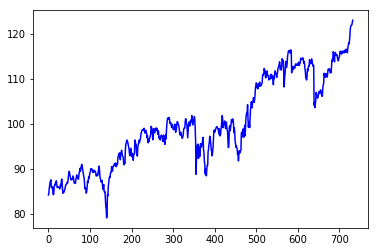

In [82]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [83]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\C51_yahoo_arch0-option_T50-history_t15-num_episodes200400-softUpdateTrue-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-120000
episode 100: 	0.039118743939606924	15.4
episode 200: 	0.034719811743809816	16.55
episode 300: 	0.03474666158428903	16.41
episode 400: 	0.03229017869788815	12.18
episode 500: 	0.03094808792569437	13.46
episode 600: 	0.03709008581693246	13.83
episode 700: 	0.03414403951768588	16.49
episode 800: 	0.031816591910411744	15.52
episode 900: 	0.037027176660293336	15.46
episode 1000: 	0.02778139243497689	15.88
episode 1100: 	0.03715324564148607	16.54
episode 1200: 	0.028185732299893105	14.88
episode 1300: 	0.03305767732682699	17.4
episode 1400: 	0.0314322409252103	14.51
episode 1500: 	0.03571994428540675	15.24
episode 1600: 	0.03589417527986988	12.79
episode 1700: 	0.0344245

episode 18600: 	0.030028110607214824	15.81
episode 18700: 	0.03276932890013022	13.49
episode 18800: 	0.03214545959866914	12.93
episode 18900: 	0.034087772345971185	17.03
episode 19000: 	0.03374060654667368	13.31
episode 19100: 	0.023876229079583484	13.35
episode 19200: 	0.02919953475110808	13.07
episode 19300: 	0.03190196716826454	15.15
episode 19400: 	0.02994768584713857	13.99
episode 19500: 	0.029798501714458716	14.41
episode 19600: 	0.02569213912535121	14.33
episode 19700: 	0.039211301157907566	15.29
episode 19800: 	0.028410925876017137	13.34
episode 19900: 	0.033377962791559385	12.23
episode 20000: 	0.04822889836721845	20.06
#Average reward per episode 20000: 0.03234096956331752
episode 20100: 	0.023775804356067538	13.37
episode 20200: 	0.03149374383204716	12.75
episode 20300: 	0.029684811583755265	15.03
episode 20400: 	0.03171225472846038	15.06
episode 20500: 	0.03296262750527887	14.54
episode 20600: 	0.02629886489209813	13.94
episode 20700: 	0.028889022202864188	13.45
episode 208

episode 37500: 	0.033138691491780004	15.85
episode 37600: 	0.03258841183101978	16.29
episode 37700: 	0.04103673821394678	14.66
episode 37800: 	0.03497146737190127	13.83
episode 37900: 	0.031027637282822075	13.13
episode 38000: 	0.03531275968116999	14.12
episode 38100: 	0.0292761515542588	14.57
episode 38200: 	0.02750684700200764	14.31
episode 38300: 	0.0358156161791506	16.75
episode 38400: 	0.042692598721253194	17.6
episode 38500: 	0.03529928953403025	14.97
episode 38600: 	0.03238196322514722	14.09
episode 38700: 	0.0325348268700731	17.07
episode 38800: 	0.02913234775592621	14.02
episode 38900: 	0.03697183809662004	16.87
episode 39000: 	0.02572039990949526	13.49
episode 39100: 	0.036176129266799	16.66
episode 39200: 	0.03172461579425406	13.32
episode 39300: 	0.03071829563019303	13.47
episode 39400: 	0.03433673279904901	16.56
episode 39500: 	0.029321849529033918	15.09
episode 39600: 	0.02690246062984741	16.31
episode 39700: 	0.03966555017071029	17.43
episode 39800: 	0.029011503827414117

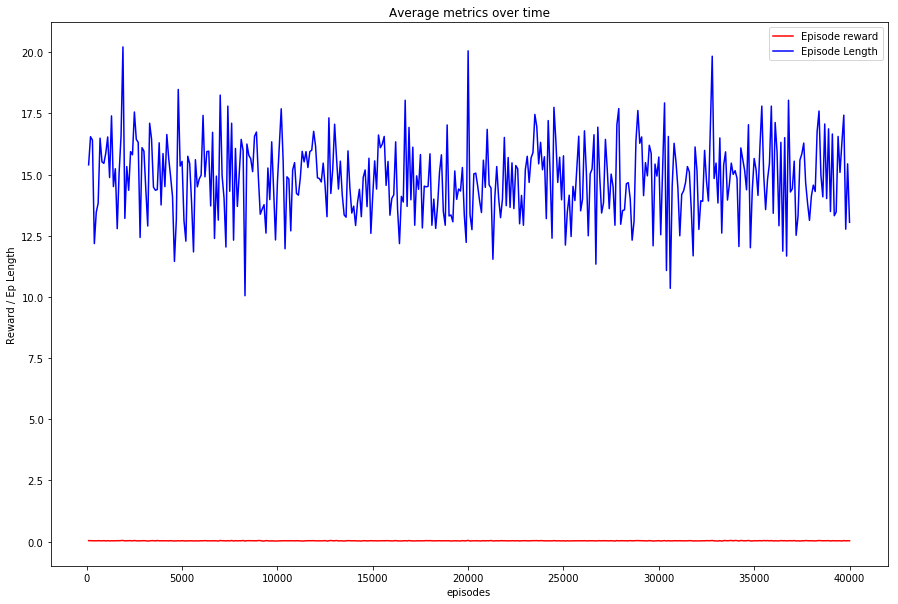

In [85]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

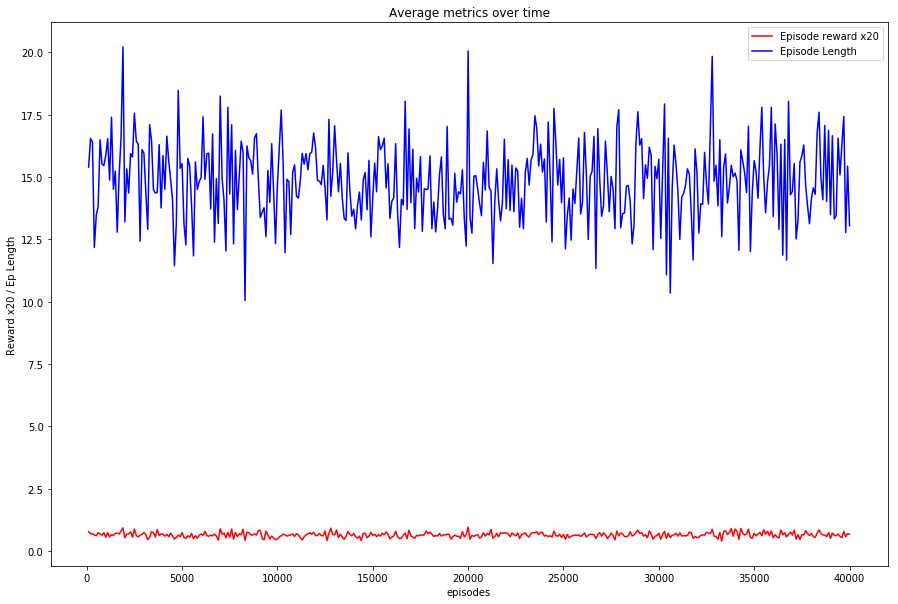

In [86]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

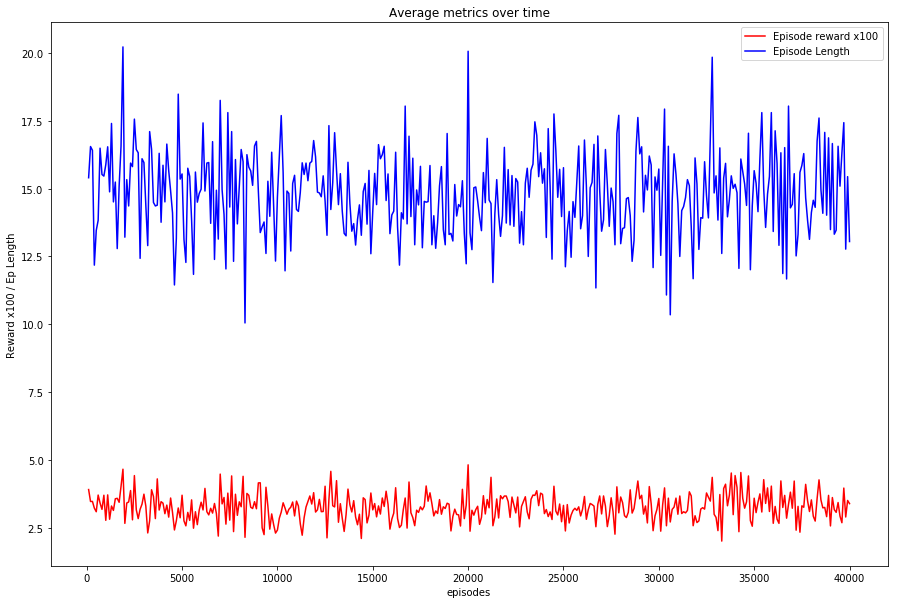

In [87]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

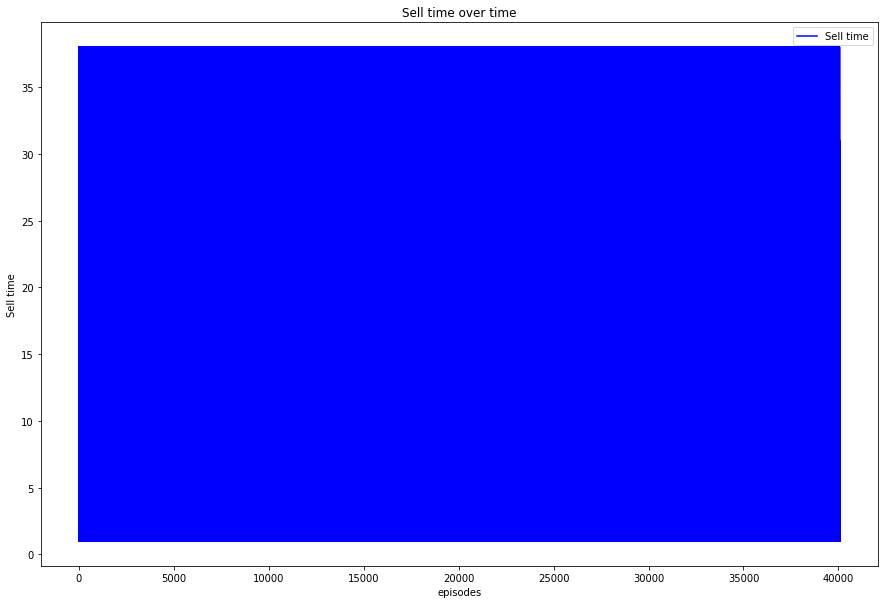

In [88]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

### Testing the network

In [11]:
load_model = True #Whether to load a saved model.
is_training = False
e=0

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 110
num_episodes_per_epoch: 7080
min value of stock: 121.705, max value of stock: 147.02499999999998


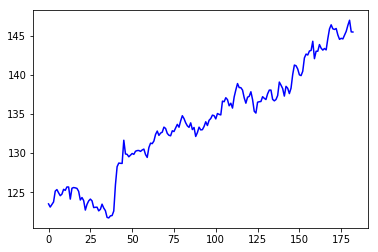

In [12]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [13]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\C51_yahoo_arch0-option_T50-history_t15-num_episodes200400-softUpdateTrue-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-120000
episode 100: 	0.010962037489016661	10.41
ep

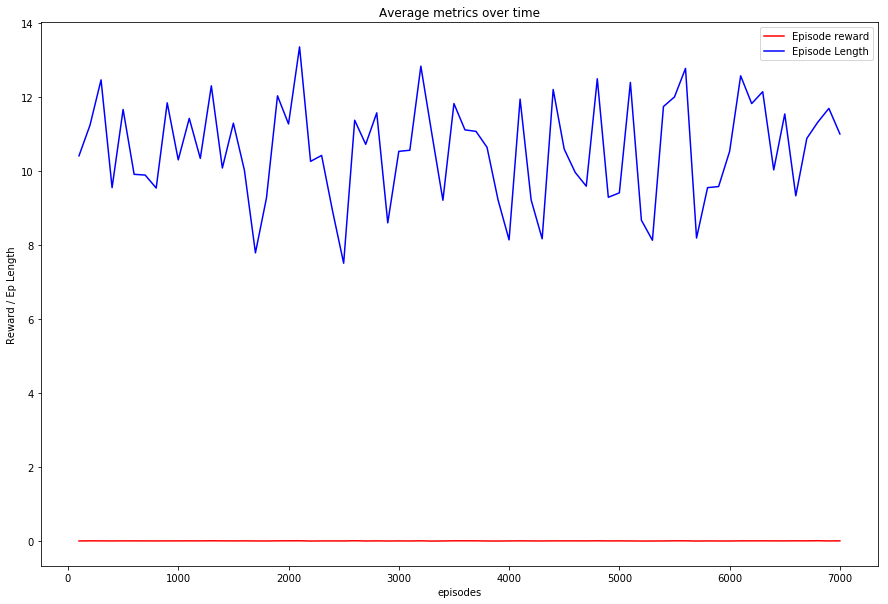

In [15]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

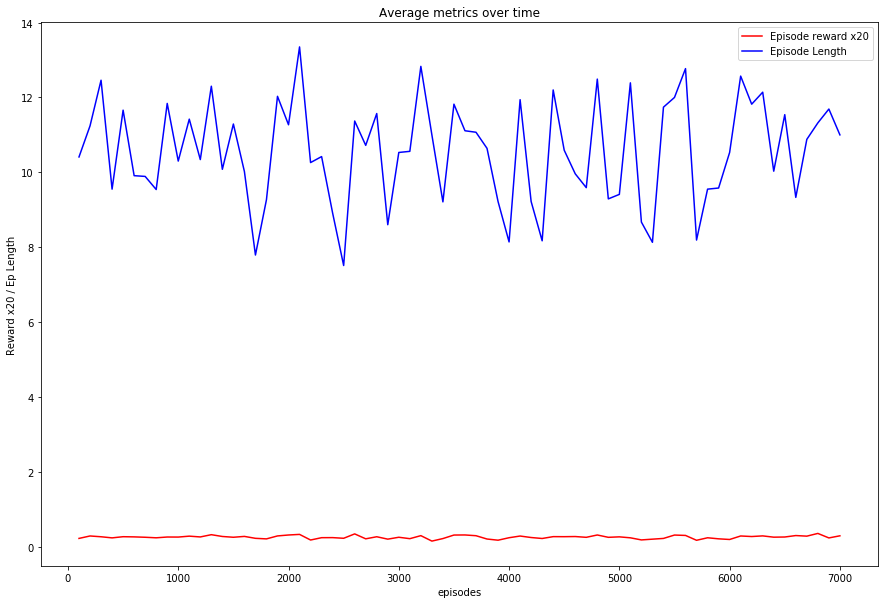

In [16]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

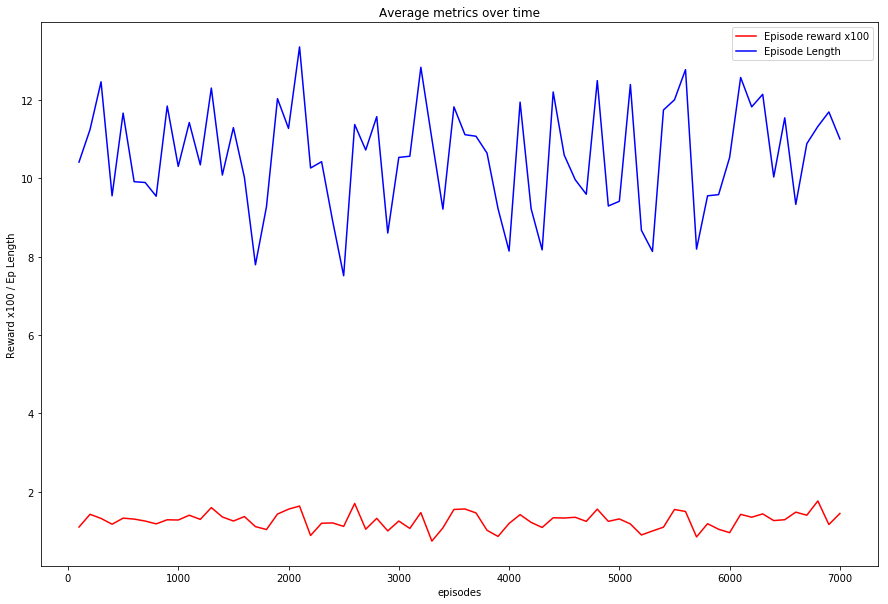

In [17]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

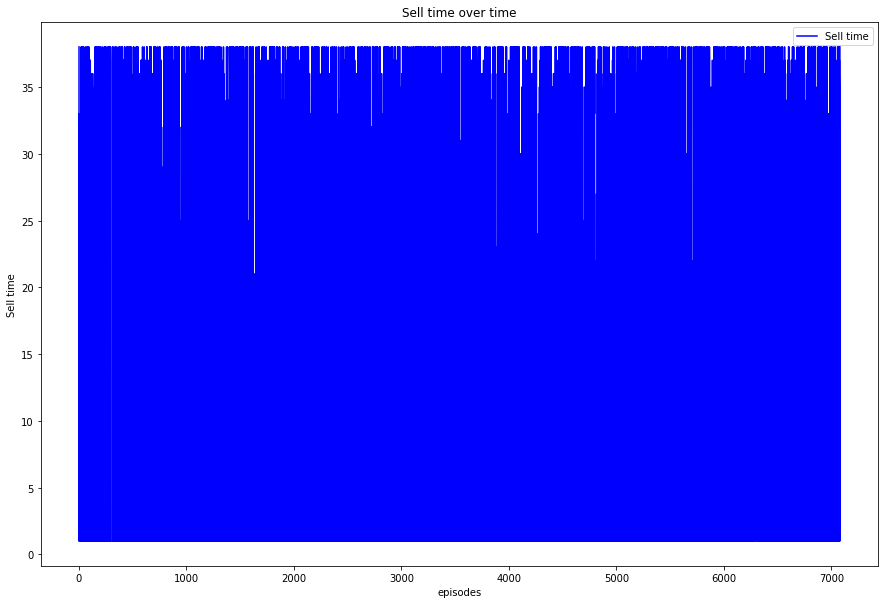

In [18]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Max price over history [Benchmark]

In [19]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
# Have a look at the RL notebook for more correct tests (slightly changed)
begin_time = time.time()

test = 'MaxValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(1,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.008499253350724625	9.51	0
episode 200: 	0.012840728967982738	11.36	0
episode 300: 	0.013252953811328716	12.84	0
episode 400: 	0.010144169278408981	10.25	0
episode 500: 	0.01477261023855517	11.73	0
episode 600: 	0.012624041293153573	10.62	0
episode 700: 	0.012685152741312978	10.25	0
episode 800: 	0.010183184835164791	9.14	0
episode 900: 	0.011158109887987808	12.1	0
episode 1000: 	0.014037358874459354	10.62	0
episode 1100: 	0.015406984565344941	12.84	0
episode 1200: 	0.012084104352434758	10.99	0
episode 1300: 	0.013658610130456949	12.84	0
episode 1400: 	0.013634256076332053	11.36	0
episode 1500: 	0.010510622175477248	11.73	0
episode 1600: 	0.015229153231330395	10.99	0
episode 1700: 	0.0072527801836126315	8.03	0
episode 1800: 	0.01019461230136778	9.51	0
episode 1900: 	0.014023391067739872	12.47	0
episode 2000: 	0.013466339933498977	12.84	0
episode 2100: 	0.011050391222114035	13.21	0
episode 2200: 	0.008862618033548595	10.25	0
episode 2300: 	0.012536840215538246	10.25	0
epi

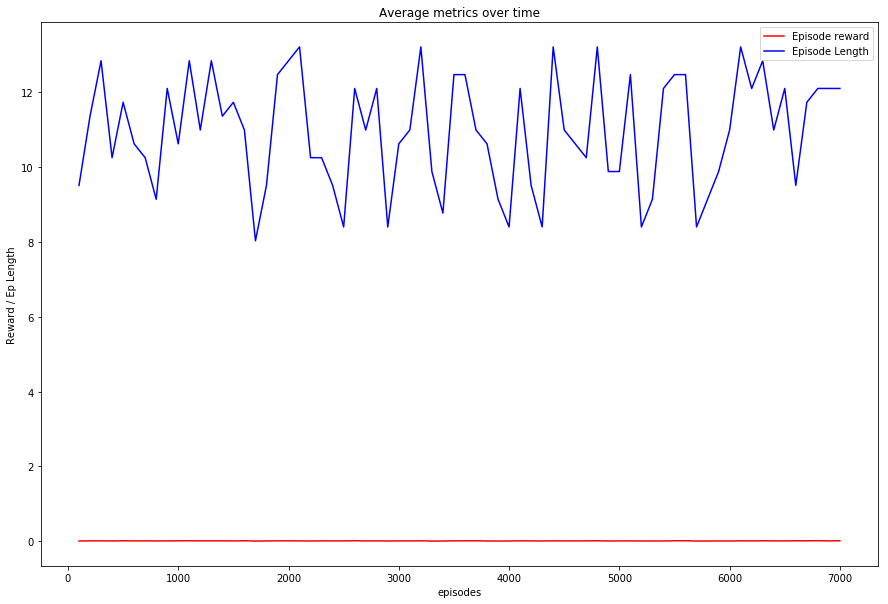

In [21]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

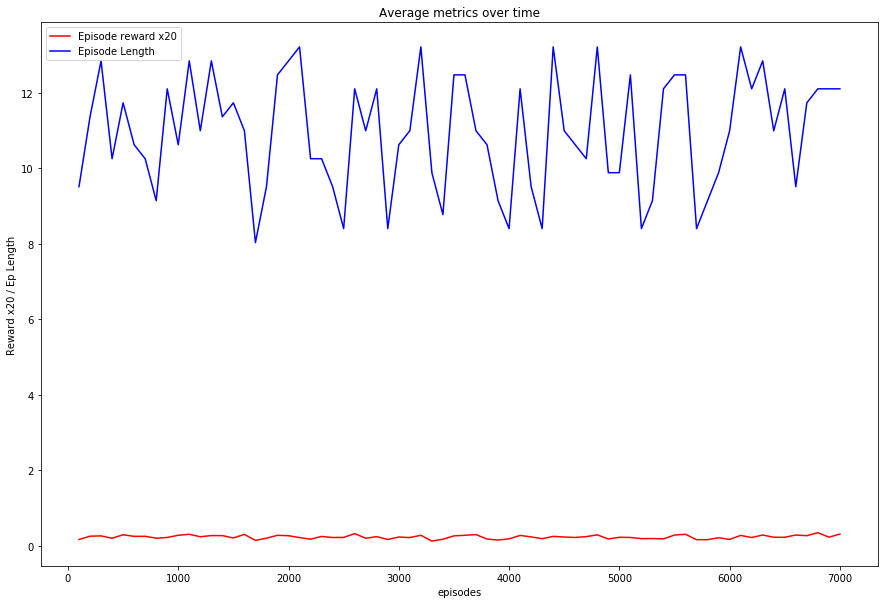

In [22]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

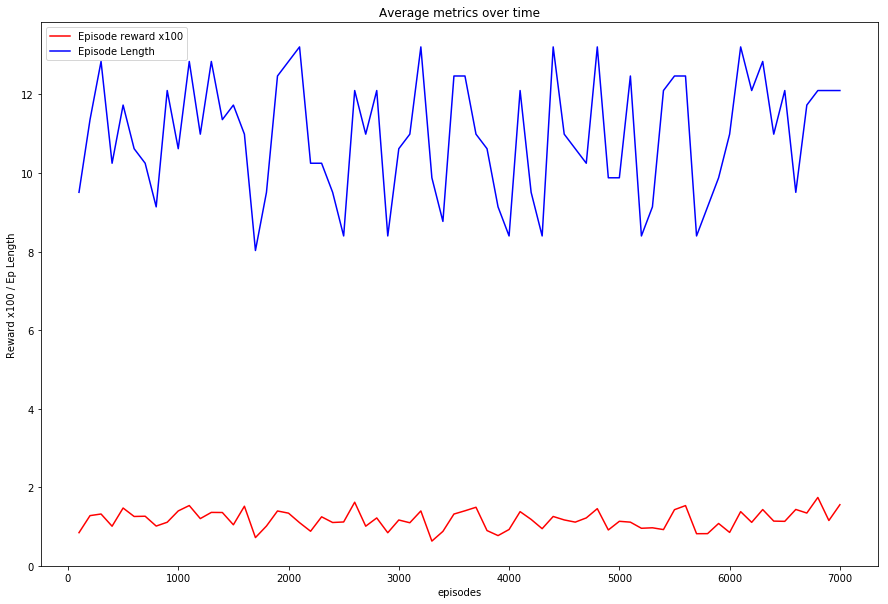

In [23]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

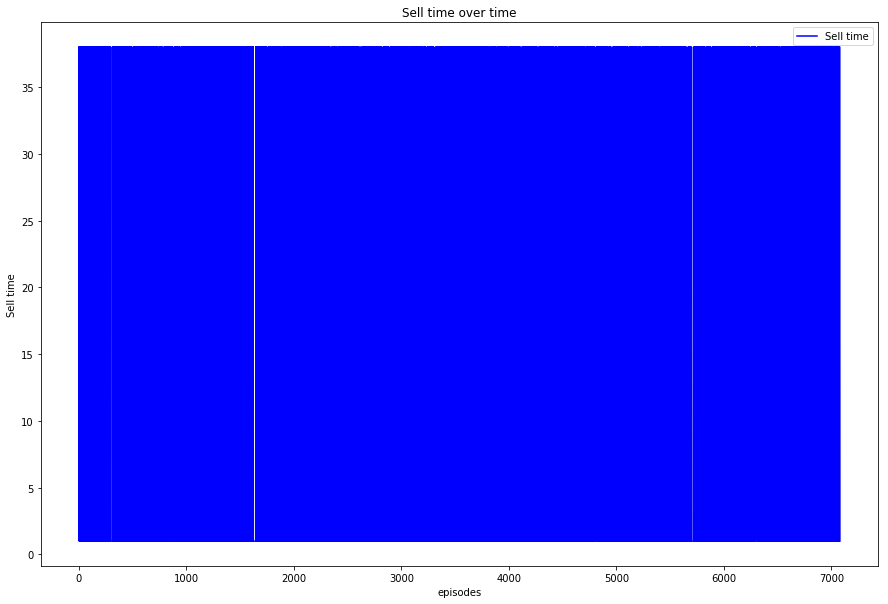

In [24]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [25]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(1,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))    

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.010362296509099398	9.48	0
episode 200: 	0.016074297282965867	10.64	0
episode 300: 	0.014447014459320085	11.34	0
episode 400: 	0.010005788502864299	9.6	0
episode 500: 	0.010370222607911843	10.5	0
episode 600: 	0.013016487814054314	10.02	0
episode 700: 	0.012707687960344216	9.4	0
episode 800: 	0.011846924835269931	9.6	0
episode 900: 	0.011307268404728928	8.92	0
episode 1000: 	0.012969560707833618	10.02	0
episode 1100: 	0.01697619261668169	11.96	0
episode 1200: 	0.012818072905120034	9.79	0
episode 1300: 	0.013212376958075043	10.57	0
episode 1400: 	0.01628188562374593	11.02	0
episode 1500: 	0.016015701533309855	12.14	0
episode 1600: 	0.012304515370174032	9.01	0
episode 1700: 	0.006788391128182421	7.64	0
episode 1800: 	0.01291787776274941	9.14	0
episode 1900: 	0.013404573605374828	11.54	0
episode 2000: 	0.016723283475615427	11.02	0
episode 2100: 	0.012026827622786108	12.66	0
episode 2200: 	0.01220506691504234	9.97	0
episode 2300: 	0.010578865024803213	9.61	0
episode 2400: 	0

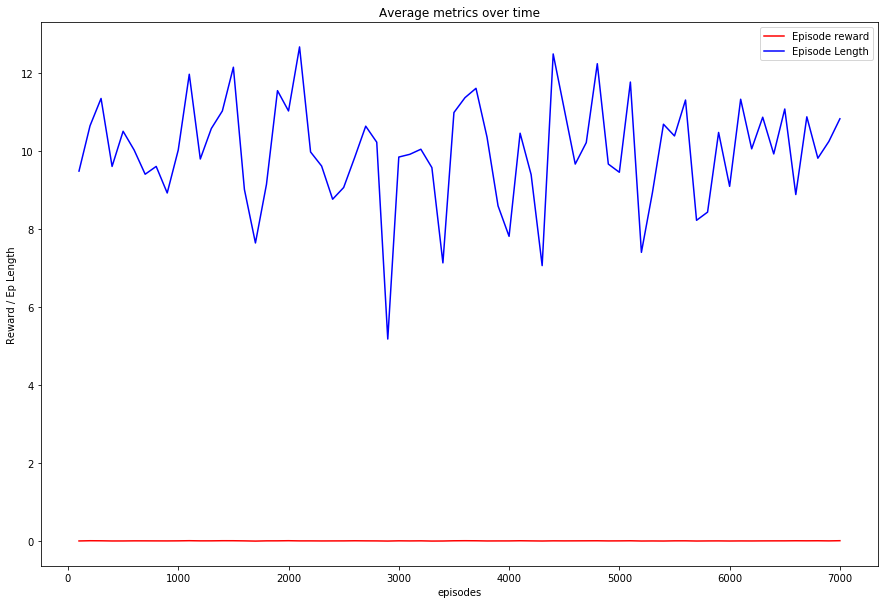

In [27]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

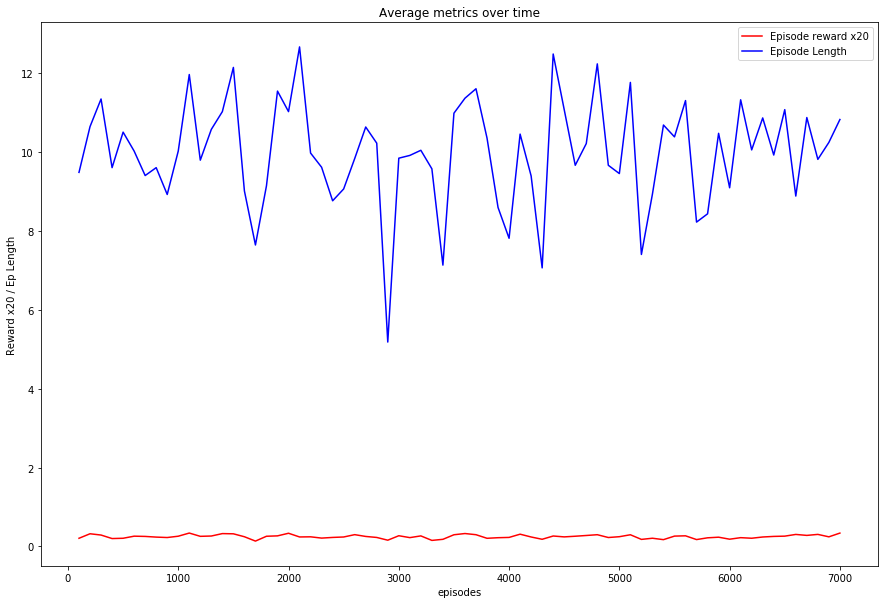

In [28]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

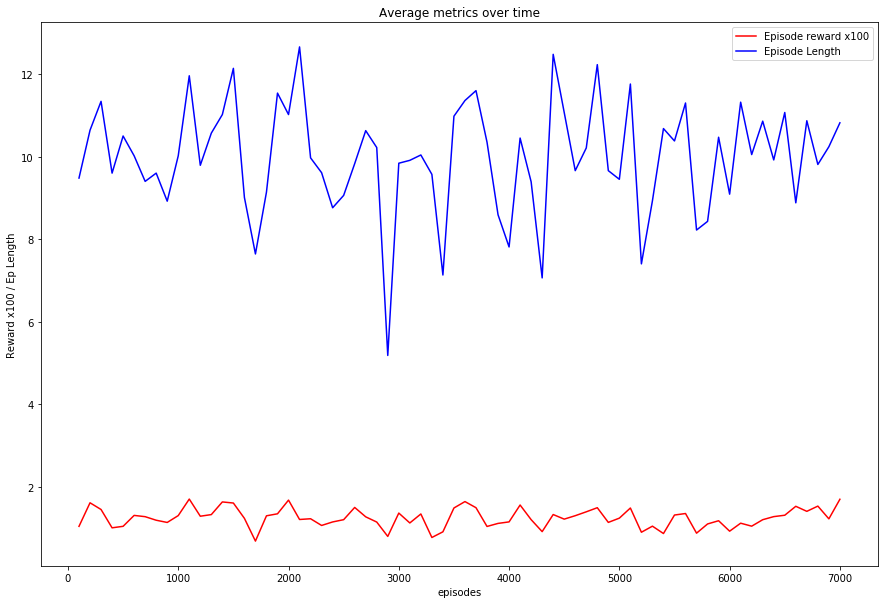

In [29]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

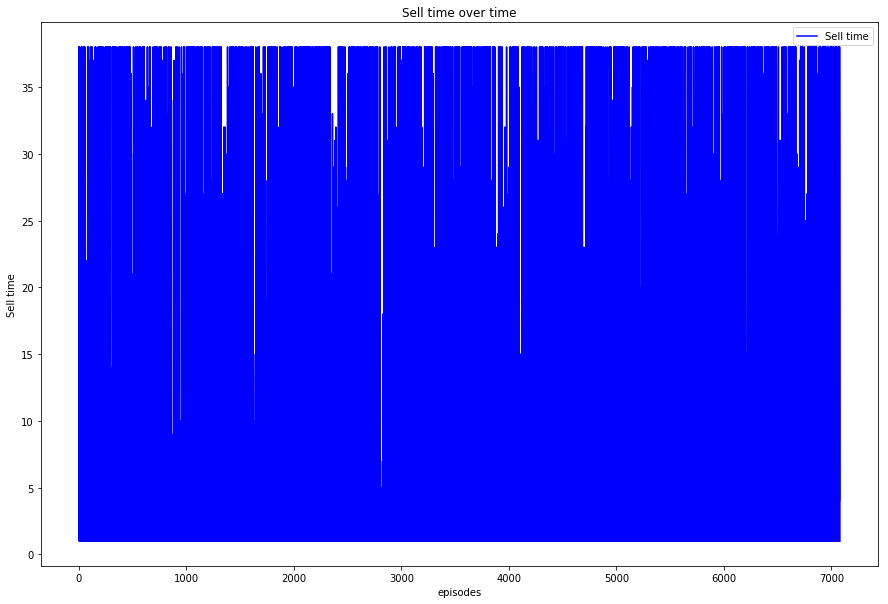

In [30]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [31]:
env.reset_new_test() # reset to first observation in data (not sure if necessary but just to erase doubt)
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []  

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(1,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT)+ '\t'+ str(e))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.008499253350724625	9.51	0
episode 200: 	0.012840728967982738	11.36	0
episode 300: 	0.013252953811328716	12.84	0
episode 400: 	0.010144169278408981	10.25	0
episode 500: 	0.01477261023855517	11.73	0
episode 600: 	0.012624041293153573	10.62	0
episode 700: 	0.012685152741312978	10.25	0
episode 800: 	0.010183184835164791	9.14	0
episode 900: 	0.011158109887987808	12.1	0
episode 1000: 	0.014037358874459354	10.62	0
episode 1100: 	0.015406984565344941	12.84	0
episode 1200: 	0.012084104352434758	10.99	0
episode 1300: 	0.013658610130456949	12.84	0
episode 1400: 	0.013634256076332053	11.36	0
episode 1500: 	0.010510622175477248	11.73	0
episode 1600: 	0.015229153231330395	10.99	0
episode 1700: 	0.0072527801836126315	8.03	0
episode 1800: 	0.01019461230136778	9.51	0
episode 1900: 	0.014023391067739872	12.47	0
episode 2000: 	0.013466339933498977	12.84	0
episode 2100: 	0.011050391222114035	13.21	0
episode 2200: 	0.008862618033548595	10.25	0
episode 2300: 	0.012536840215538246	10.25	0
epi

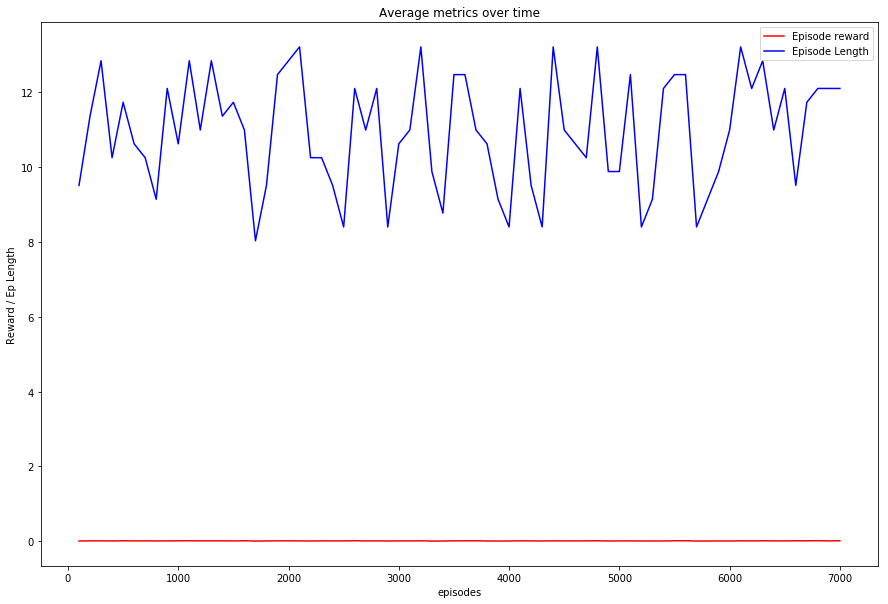

In [33]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

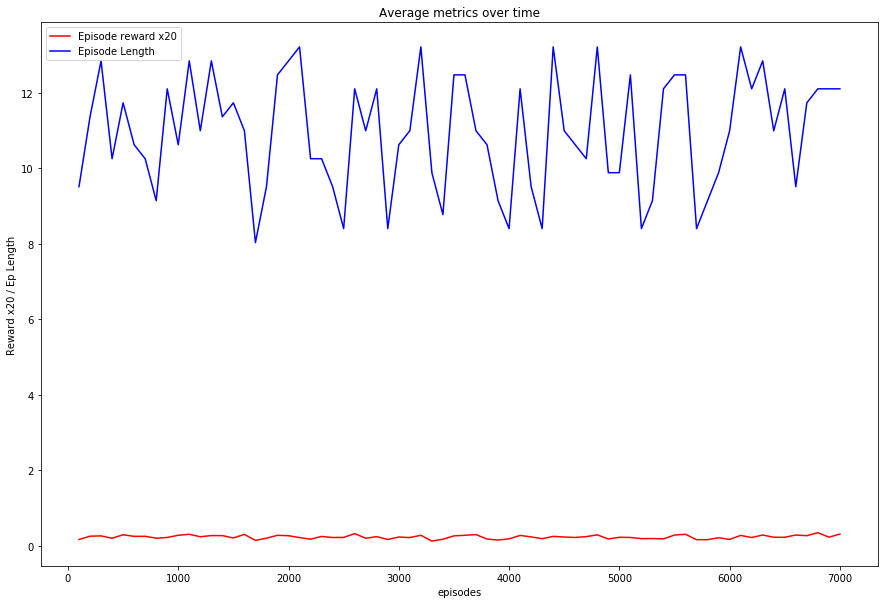

In [34]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

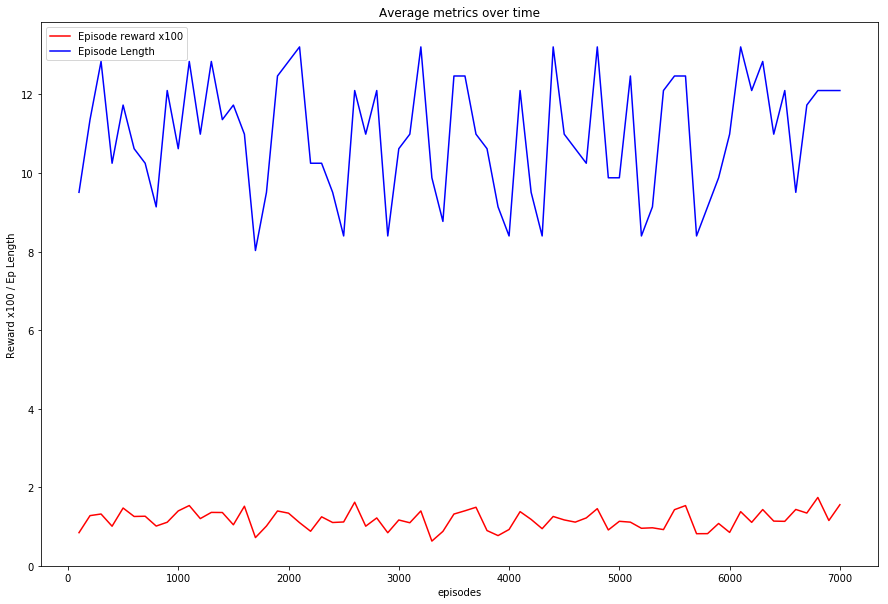

In [35]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

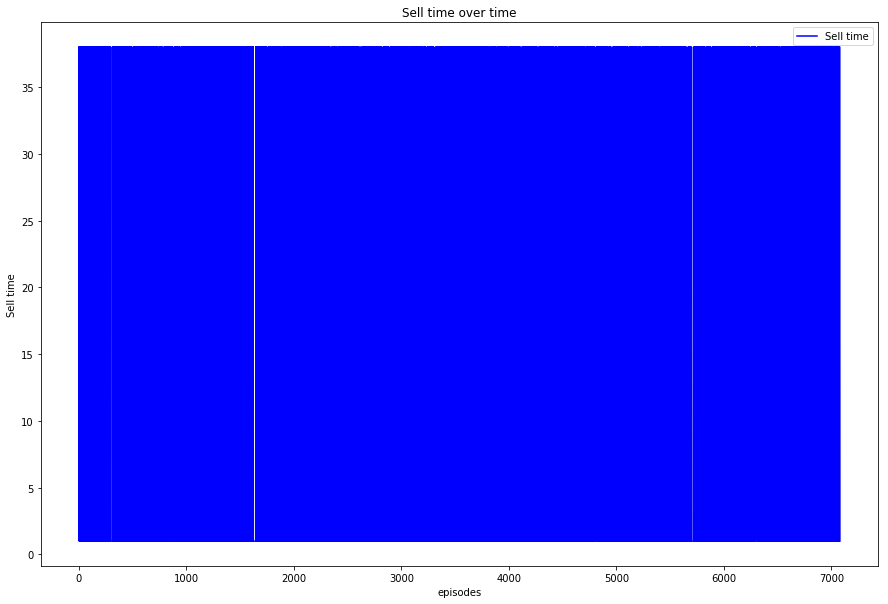

In [36]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Validation part (1)

##t.us.txtmin date: 1984-07-19max date: 2017-11-10
min value of data: 27.646, max value of data: 40.954
train_size: 733
test_size: 183
##gm.us.txtmin date: 2010-11-17max date: 2017-11-10
min value of data: 24.1665, max value of data: 46.239999999999995
train_size: 733
test_size: 183
##cvs.us.txtmin date: 1984-12-17max date: 2017-11-10
min value of data: 68.035, max value of data: 107.81
train_size: 733
test_size: 183
##unh.us.txtmin date: 1990-03-26max date: 2017-11-10
min value of data: 70.606, max value of data: 212.865
train_size: 733
test_size: 183
##xom.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 63.616, max value of data: 91.847
train_size: 733
test_size: 183
##wmt.us.txtmin date: 1972-03-20max date: 2017-11-10
min value of data: 53.5275, max value of data: 90.945
train_size: 733
test_size: 183
##mck.us.txtmin date: 1994-11-15max date: 2017-11-10
min value of data: 121.72999999999999, max value of data: 238.81
train_size: 733
test_size: 183
##aat.us.txtmin d

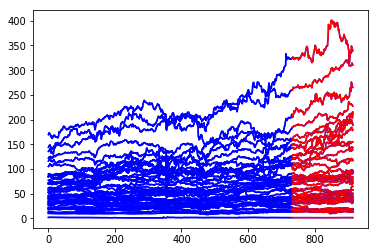

In [37]:
stock_names = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',
               'xom.us.txt', 'wmt.us.txt', 'mck.us.txt', # , 'brk-a.us.txt'
               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', 'acta.us.txt',
               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',
              'pay.us.txt', 'peg.us.txt', 'tg.us.txt', 'tis.us.txt',
              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',
              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',
               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',
               'bbl.us.txt', 'ry.us.txt', 'asml.us.txt', 'nee.us.txt', 
              'txn.us.txt', 'gsk.us.txt', 'lly.us.txt', 'nvo.us.txt',
               'td.us.txt', 'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',
               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt',
              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']
# unvalid stocks: 'kst.us.txt', 'ddt.us.txt', 'lgl.us.txt', 'aac.us.txt','adom.us.txt','acrs.us.txt', 'delt.us.txt', 'lcahu.us.txt', 'tpge.us.txt', 'wear.us.txt'

stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 92
num_episodes_per_epoch: 5900
min value of stock: 56.837999999999994, max value of stock: 75.2365


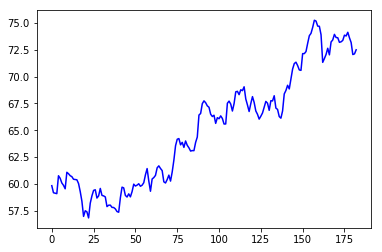

In [39]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [40]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\C51_yahoo_arch0-option_T50-history_t15-num_episodes200400-softUpdateTrue-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-120000
episode 100: 	0.022956436407930644	12.0
episode 200: 	0.016759659248144213	10.18
episode 300: 	0.018072411083654337	11.93
episode 400: 	0.01887069214366466	10.61
episode 500: 	0.014811567868552327	11.51
episode 600: 	0.013704688526604357	10.66
episode 700: 	0.02228738622237561	11.89
episode 800: 	0.016007267190898074	11.65
episode 900: 	0.014361164395860042	11.92
episode 1000: 	0.011728794071552416	9.85
episode 1100: 	0.01642397976474734	11.93
episode 1200: 	0.015490543625677134	10.83
episode 1300: 	0.019545510113657884	13.9
episode 1400: 	0.018111408956984324	11.73
episode 1500: 	0.011434702320154226	8.76
episode 1600: 	0.014816624959786515	9.62
episode 1700: 	0.0

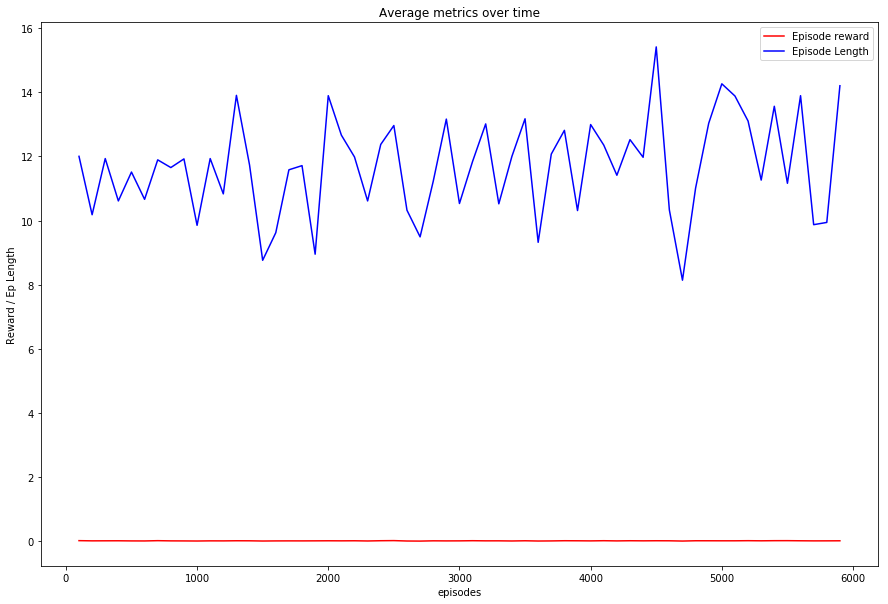

In [42]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

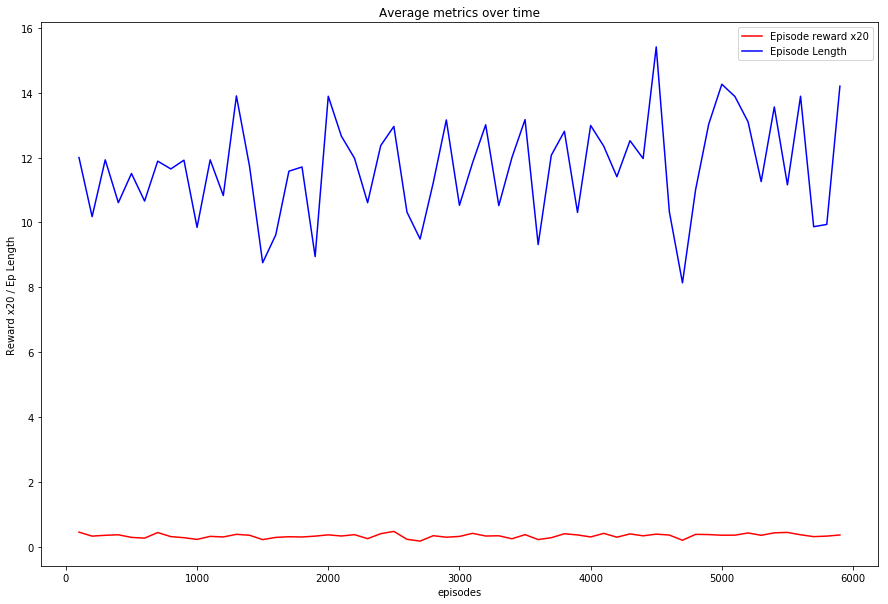

In [43]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

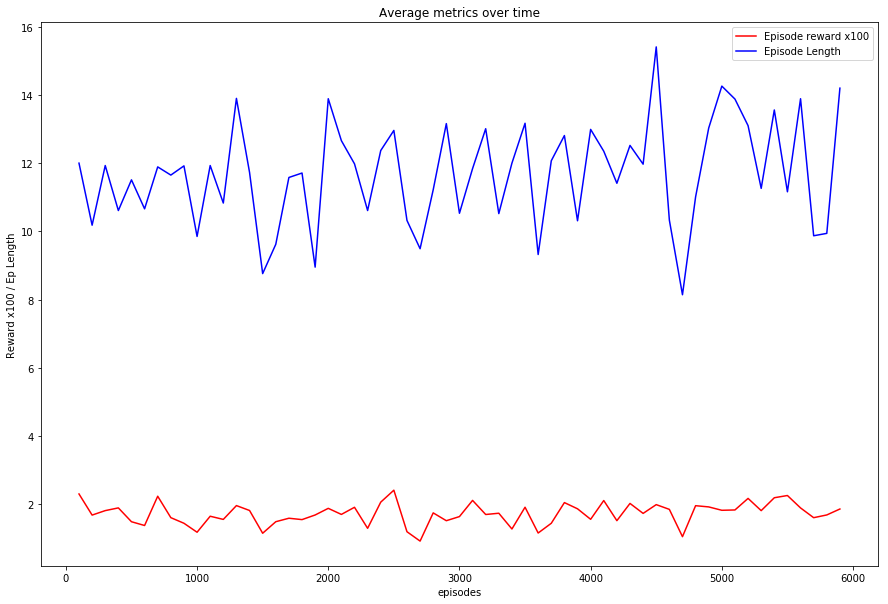

In [44]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

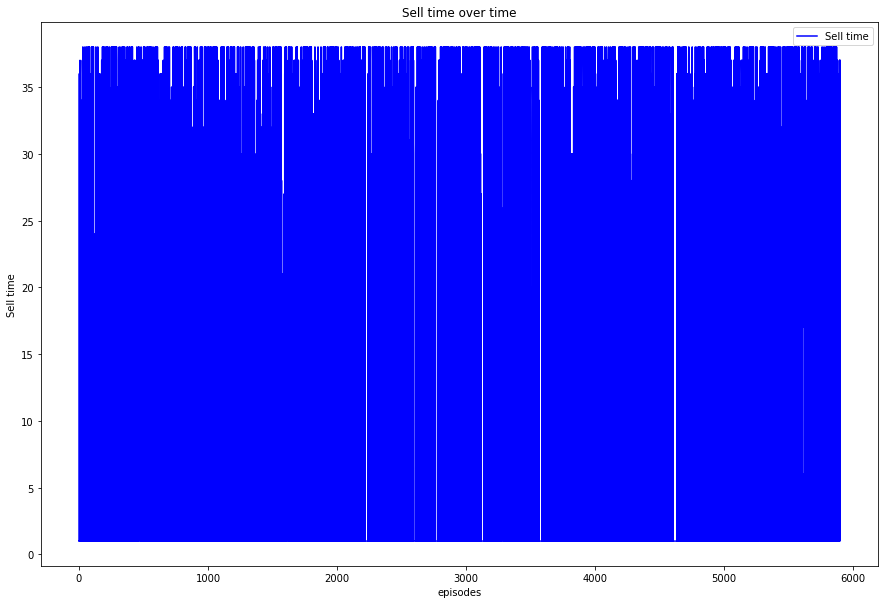

In [45]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 521
num_episodes_per_epoch: 33400
min value of stock: 34.557500000000005, max value of stock: 60.243500000000004


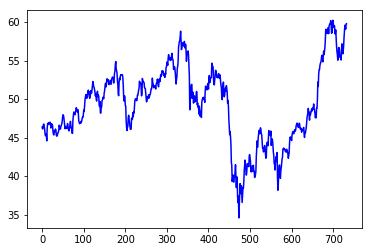

In [46]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [47]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\C51_yahoo_arch0-option_T50-history_t15-num_episodes200400-softUpdateTrue-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-120000
episode 100: 	0.035516866690599794	16.06
episode 200: 	0.03503266153562897	17.38
episode 300: 	0.034674606406542324	14.17
episode 400: 	0.03627557170100793	13.25
episode 500: 	0.04158127247884519	16.76
episode 600: 	0.034248366518744494	15.88
episode 700: 	0.03897245731046531	14.68
episode 800: 	0.03633839696496668	16.82
episode 900: 	0.027855344760728838	15.65
episode 1000: 	0.0322324685174196	17.27
episode 1100: 	0.03143755896255952	18.71
episode 1200: 	0.029596179271888887	14.58
episode 1300: 	0.028099841292674066	15.0
episode 1400: 	0.03318623296236216	16.13
episode 1500: 	0.03560241118396396	14.13
episode 1600: 	0.02408044867525589	13.41
episode 1700: 	0.02826

episode 18600: 	0.035494659940748546	16.51
episode 18700: 	0.022029121513282717	13.98
episode 18800: 	0.0386812284453002	14.55
episode 18900: 	0.024034652569670332	14.95
episode 19000: 	0.03549013663499531	16.21
episode 19100: 	0.028999509956661843	14.85
episode 19200: 	0.038060893964183204	15.52
episode 19300: 	0.022151168168941138	13.96
episode 19400: 	0.03434139332032332	16.24
episode 19500: 	0.02849064081066209	15.59
episode 19600: 	0.02730408437362718	17.16
episode 19700: 	0.02913353488218997	17.0
episode 19800: 	0.036707669074307614	16.03
episode 19900: 	0.03188034250633386	14.32
episode 20000: 	0.03576896551322188	17.9
#Average reward per episode 20000: 0.03080797043105613
episode 20100: 	0.02619473129975196	14.62
episode 20200: 	0.029816753377739577	13.36
episode 20300: 	0.030595550352269334	13.76
episode 20400: 	0.02505365101663132	14.91
episode 20500: 	0.031134137133477943	15.12
episode 20600: 	0.028889333017496025	16.8
episode 20700: 	0.03602714283750211	15.74
episode 20800:

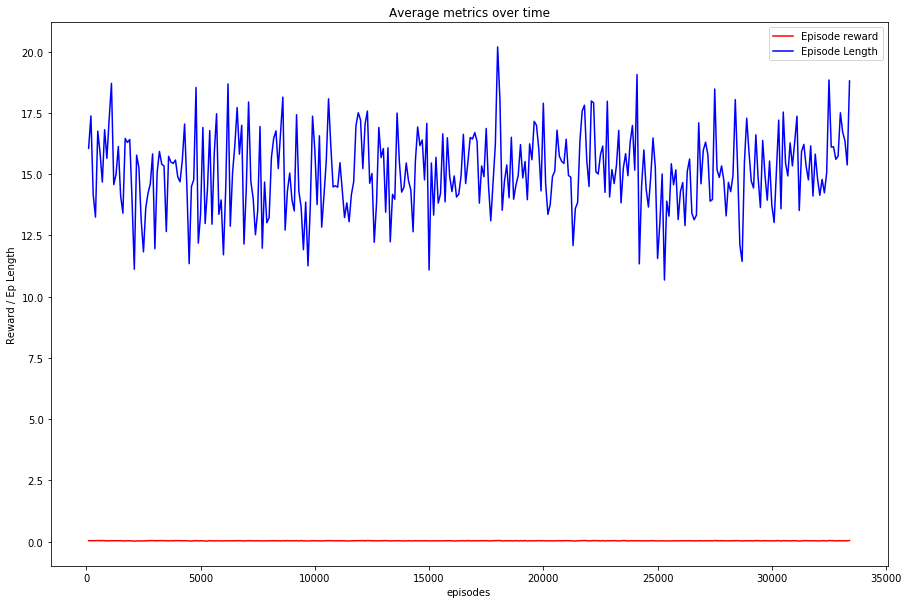

In [49]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

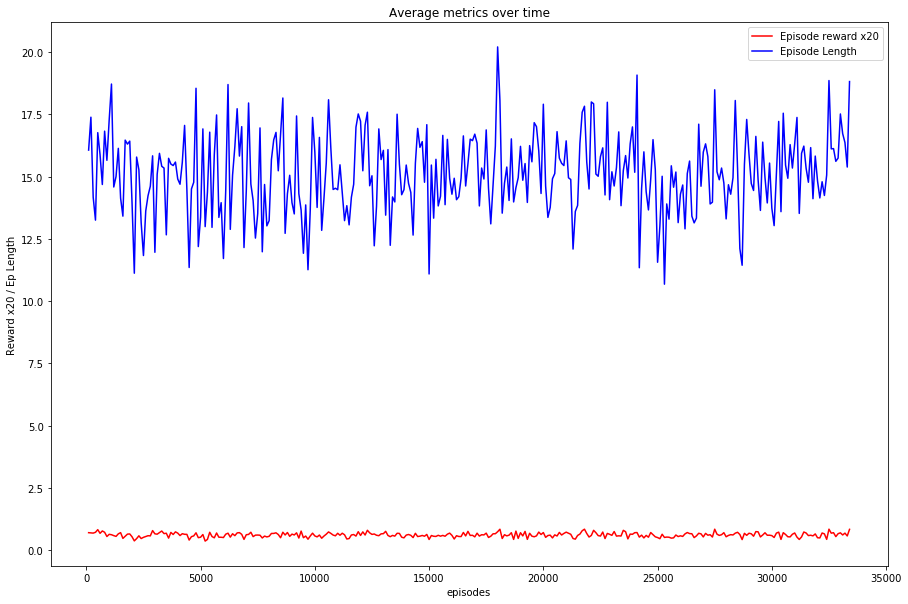

In [50]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

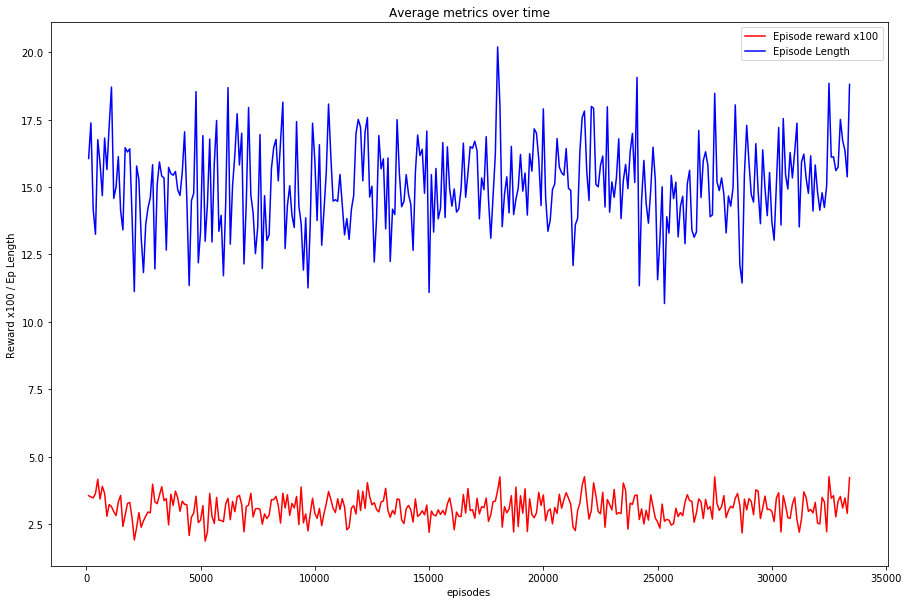

In [51]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

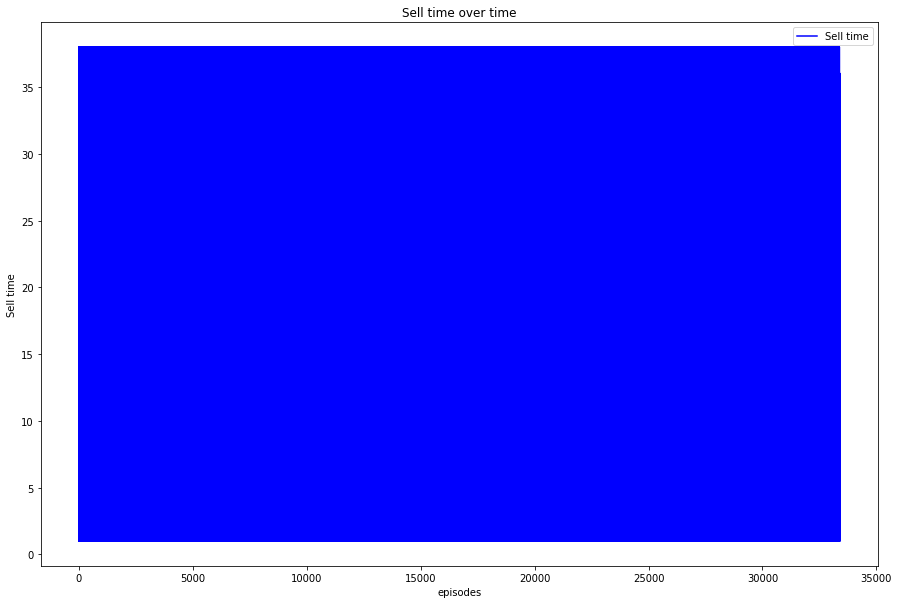

In [52]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Validation part

In [54]:
test_data_ratio = 0.6

['HPQ', 'AAPL', 'GOOG', 'UPS', 'JNJ', 'MSFT', 'PG', 'TSN', 'USA', 'TEX', 'SAM', 'SALT', 'TLYS', 'TRQ', 'TRNO', 'TNP', 'TJX', 'TPX', 'FB', 'JPM', 'V', 'BAC', 'MA', 'HD', 'TSM', 'DIS', 'INTC', 'VZ', 'RDS-B', 'TM', 'CVX', 'WFC', 'NVS', 'KO', 'MRK', 'CMCSA', 'SAP', 'CHL', 'UL', 'BUD', 'UN', 'WFC', 'MDT', 'HSBC', 'MCD', 'NKE', 'ADBE', 'CRM', 'TOT', 'PTR', 'COST', 'PM', 'AMGN', 'ABBV', 'HON', 'T', 'GM', 'CVS', 'UNH', 'XOM', 'BRK-A', 'WMT', 'MCK', 'AAT', 'ABC', 'ACRE', 'FN', 'FNB', 'FORD', 'KRG', 'PEG', 'TG', 'NFLX', 'ACN', 'UTX', 'LMT', 'NVDA', 'AVGO', 'AZN', 'TMO', 'UNP', 'LFC', 'BHP', 'SNY', 'BBL', 'NEE', 'TXN', 'LLY', 'QCOM', 'DHR', 'CHTR', 'SBUX', 'MMM', 'AXP', 'HDB', 'TD', 'NVO', 'ASML', 'RY', 'CSCO', 'ORCL', 'C']
[*********************100%***********************]  1 of 1 completed
##HPQmin date: 2017-11-10 00:00:00max date: 2019-12-10 00:00:00
min value of data: 16.05500030517578, max value of data: 26.649999618530273
train_size: 210
test_size: 313
[*********************100%***********

[*********************100%***********************]  1 of 1 completed
##FNmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 24.55500030517578, max value of data: 61.55500030517578
train_size: 209
test_size: 313
[*********************100%***********************]  1 of 1 completed
##FNBmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 9.524999618530273, max value of data: 14.789999961853027
train_size: 209
test_size: 313
[*********************100%***********************]  1 of 1 completed
##FORDmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 0.949999988079071, max value of data: 3.3899998664855957
train_size: 209
test_size: 313
[*********************100%***********************]  1 of 1 completed
##KRGmin date: 2017-11-10 00:00:00max date: 2019-12-09 00:00:00
min value of data: 13.90999984741211, max value of data: 20.09000015258789
train_size: 209
test_size: 313
[*********************100%****************

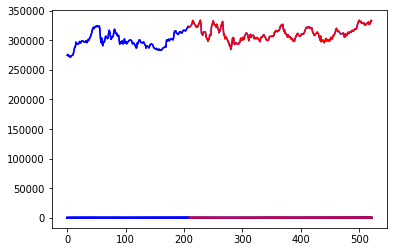

In [55]:
stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ups.us.txt', #'ibm.us.txt'
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt', #, 'trk.us.txt'
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'cmcsa.us.txt', #'pfe.us.txt', 'ba.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', #'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']

stock_names_2 = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',
               'xom.us.txt', 'brk-a.us.txt', 'wmt.us.txt', 'mck.us.txt',
               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', #'acta.us.txt',
               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',
              'peg.us.txt', 'tg.us.txt',# 'tis.us.txt', 'pay.us.txt', 
              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',
              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',
               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',
               'bbl.us.txt', 'nee.us.txt',
              'txn.us.txt', 'lly.us.txt', # 'gsk.us.txt'
               'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',
               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt', 'td.us.txt',  'nvo.us.txt', 'asml.us.txt', 'ry.us.txt',
              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']

stock_names_all = stock_names + stock_names_2
stock_names = []
#tickers_string = ""
for stock_name in stock_names_all:
    name = stock_name.split(".")[0]
    stock_names.append(name.upper())
print(stock_names)

stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock_yahoo(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r')

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 395
num_episodes_per_epoch: 25296
min value of stock: 49.364999771118164, max value of stock: 75.90999984741211


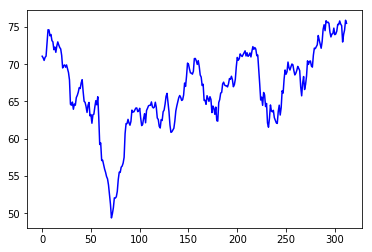

In [56]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [57]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\C51_yahoo_arch0-option_T50-history_t15-num_episodes200400-softUpdateTrue-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-120000
episode 100: 	0.01743129876110869	12.9
episode 200: 	0.0321544423867933	12.96
episode 300: 	0.03234715005417351	14.71
episode 400: 	0.02778835813358683	13.14
episode 500: 	0.029193707475022562	15.14
episode 600: 	0.0298160768884042	15.9
episode 700: 	0.02920767968951403	14.62
episode 800: 	0.028038710855842763	14.16
episode 900: 	0.02331995073600239	12.52
episode 1000: 	0.019684772978081883	10.32
episode 1100: 	0.02549828307486	12.13
episode 1200: 	0.03659723101617647	13.79
episode 1300: 	0.029624748533265147	13.02
episode 1400: 	0.03367046638135032	15.14
episode 1500: 	0.020128669923251147	12.51
episode 1600: 	0.02302783121309114	13.08
episode 1700: 	0.02565006653

episode 18600: 	0.03231550364895686	13.68
episode 18700: 	0.027874817213224205	14.87
episode 18800: 	0.02762706599662848	11.96
episode 18900: 	0.034854379684773944	13.3
episode 19000: 	0.029917876870671586	15.54
episode 19100: 	0.02363103768096523	13.12
episode 19200: 	0.02204941339681167	15.42
episode 19300: 	0.027307792043926398	13.66
episode 19400: 	0.02649306577728044	13.73
episode 19500: 	0.0304843831215618	14.34
episode 19600: 	0.036139266724359596	15.17
episode 19700: 	0.0327388771245617	12.24
episode 19800: 	0.02222095376139099	13.08
episode 19900: 	0.030191284777292885	13.97
episode 20000: 	0.025980922059544973	12.38
#Average reward per episode 20000: 0.028195567264720257
episode 20100: 	0.021738625702151123	10.6
episode 20200: 	0.02609025258875757	14.61
episode 20300: 	0.02476466422572525	11.29
episode 20400: 	0.02148117528767532	11.92
episode 20500: 	0.02747477192982722	16.33
episode 20600: 	0.024771775154053738	12.86
episode 20700: 	0.028927796412447245	13.76
episode 20800:

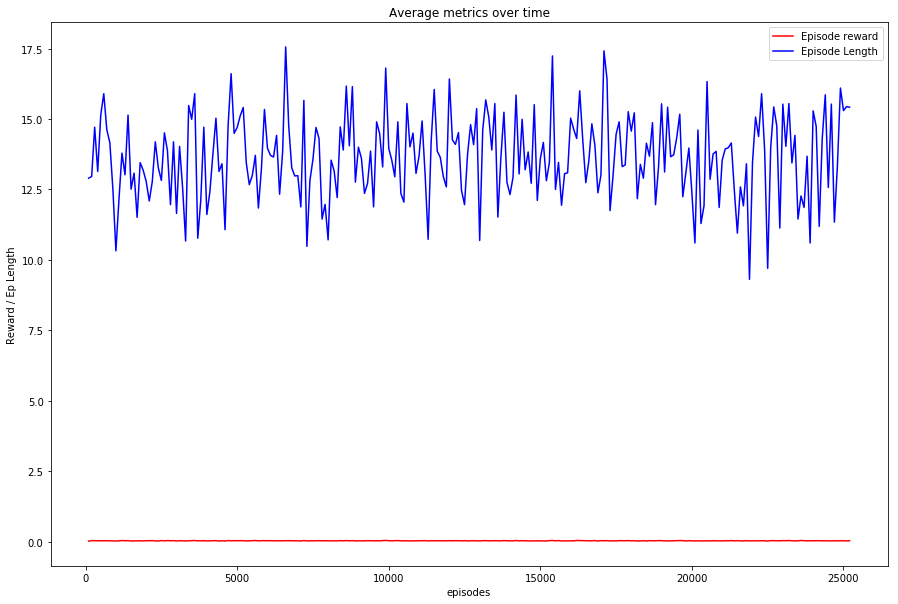

In [59]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

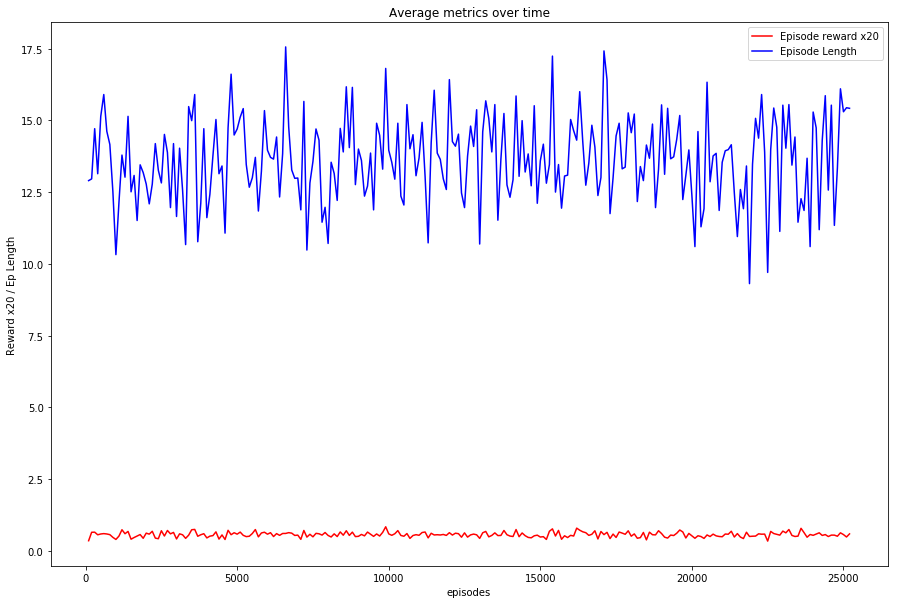

In [60]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

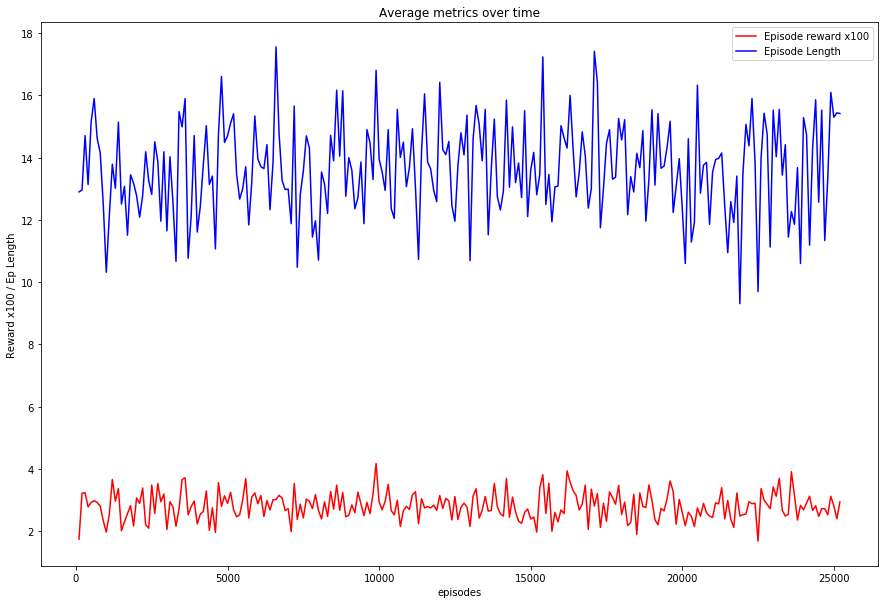

In [61]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

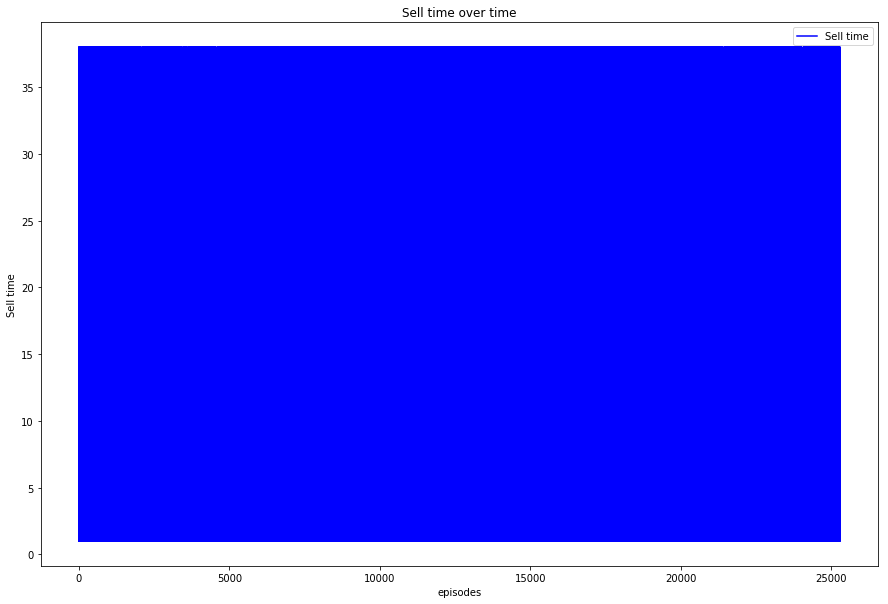

In [62]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 229
num_episodes_per_epoch: 14689
min value of stock: 65.53499984741211, max value of stock: 80.26499938964844


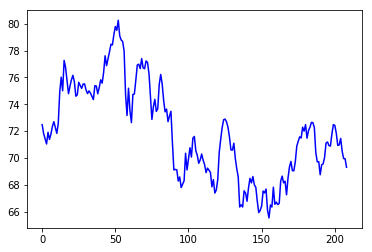

In [63]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [64]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                else:
                    a = a[0]
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from C:\Code_RL\normalizeFirstDay_seed_corrected_2019_11_21_shuffled_REAL_stocks_version\savedModel\C51_yahoo_arch0-option_T50-history_t15-num_episodes200400-softUpdateTrue-tau0.001-dropout0.19999999999999996True-num_layers3-freq30-batch64-capacity3000-lambda0.0025-120000
episode 100: 	0.024700635152085138	13.49
episode 200: 	0.03199740939372316	16.33
episode 300: 	0.025010012295382834	14.82
episode 400: 	0.029938333837705087	15.36
episode 500: 	0.034334110807871326	16.13
episode 600: 	0.024056921759561343	15.24
episode 700: 	0.024647644005321278	13.85
episode 800: 	0.03139702333028787	18.0
episode 900: 	0.038244334237616535	19.61
episode 1000: 	0.037588256595720466	16.51
episode 1100: 	0.02653985104162368	15.71
episode 1200: 	0.028599647050637923	14.89
episode 1300: 	0.03145525592143567	19.08
episode 1400: 	0.02015350912494723	15.65
episode 1500: 	0.027829726204773742	14.34
episode 1600: 	0.027388813352159588	17.3
episode 1700: 	0.

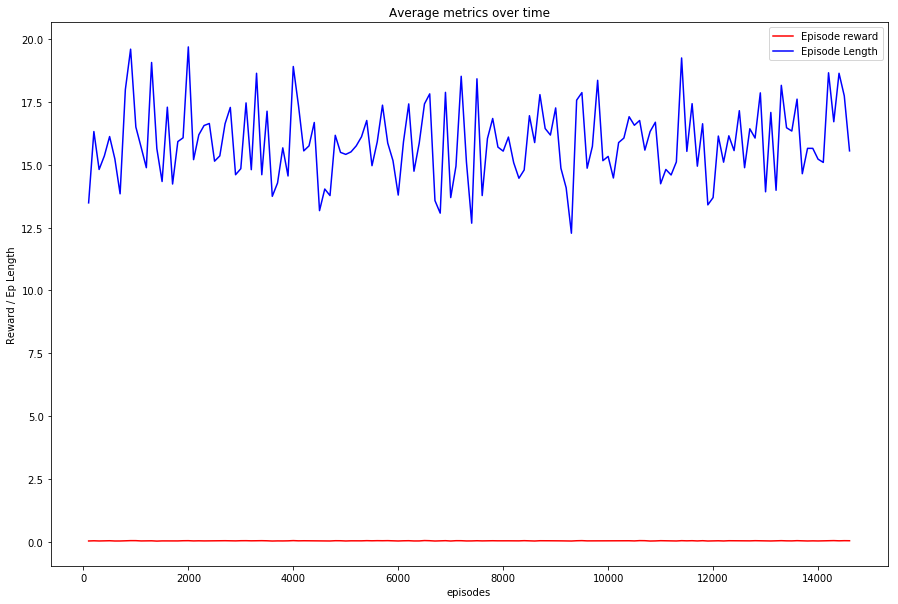

In [66]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

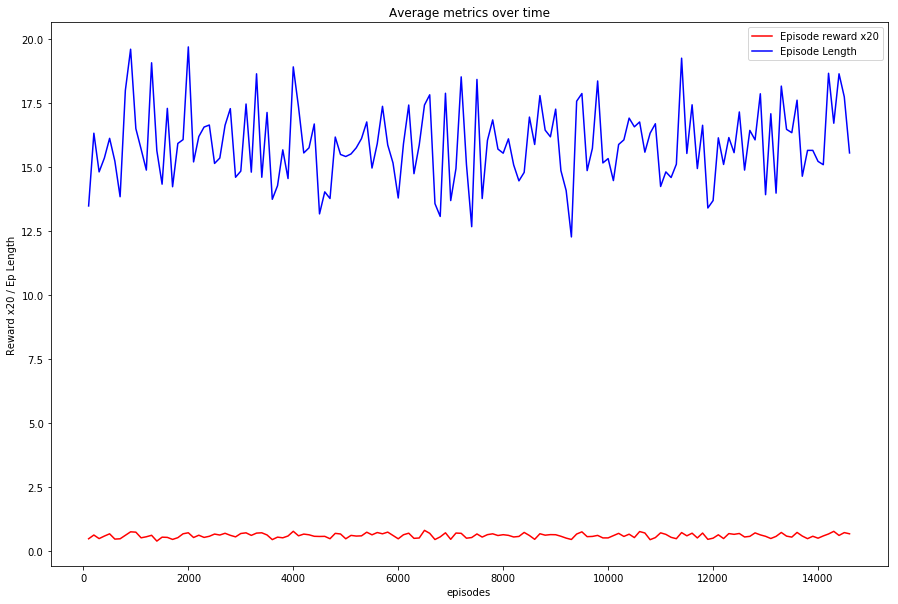

In [67]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

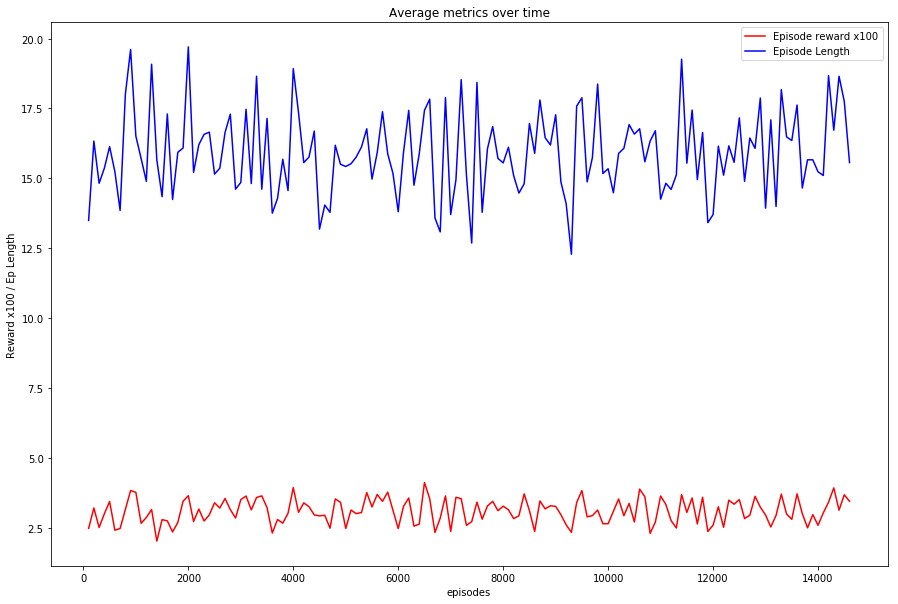

In [68]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

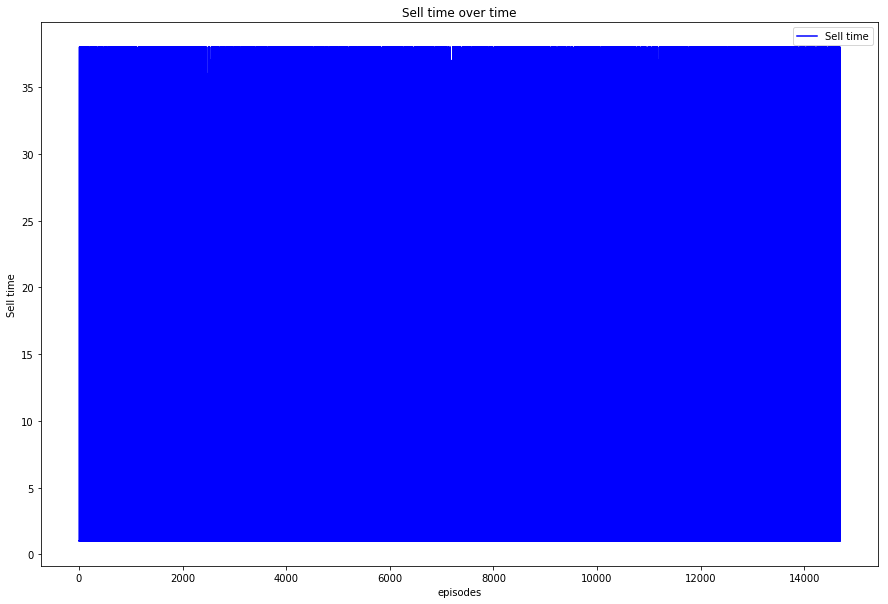

In [69]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Print size of remaining objects

In [70]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
list_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#print(list_objects)
for x,y in list_objects:
    print(str(x)+": "+str(y))
    del x

jList: 124920
maxPossibleOptionP_returnList: 124920
maxPossibleOptionR_P_returnList: 124920
maxPossibleP_returnList: 124920
maxPossibleR_P_returnList: 124920
maxPossiblerList: 124920
option_percentage_rList: 124920
option_real_percentage_rList: 124920
percentage_rList: 124920
rList: 124920
real_percentage_rList: 124920
sTimeList: 124920
real_test_data: 2600
test_data: 2600
Qnetwork: 2000
real_train_data: 1768
train_data: 1768
AvgEpisodeList: 1248
AvgrList: 1248
AvgsTimeList: 1248
AmericanOptionPricing: 1056
GBM: 1056
MinMaxScaler: 1056
experience_buffer: 1056
real_stocks_test_data: 912
real_stocks_train_data: 912
stock_names: 912
stocks_test_data: 912
stocks_train_data: 912
stock_names_all: 880
episodeBuffer: 528
stock_names_2: 440
path: 333
final_trained_model_name: 316
trained_model_name: 309
s1P: 232
sP: 232
build_data: 136
leaky_relu: 136
length: 136
normalize_data: 136
prepare_company_stock: 136
prepare_company_stock_yahoo: 136
prepare_data: 136
processState: 136
set_seed: 136
upd